# Solving eigenvalue problems using Neural Network

In this jupyter notebook it will be demonstrated how we obtain our results in the report that corresponds to finding the eigenvalues of a given matrix. 

First off, we will need to import some libraries.

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import axes3d
import tqdm as tqdm
import os
import seaborn as sns

/home/oliver/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/oliver/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/oliver/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/oliver/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

Then, we would like the format of the figures to be neat and in correct font. 

In [2]:
# Defining values for nice plotting
plt.rcParams["font.family"]= "Times New Roman"
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
sns.set()

We can then make two different arrays where the analytical eigenvalues of one of them are already known. 

In [3]:
is_it_known = False 
matrix_size = 6

if is_it_known==True:
    # Defining analytical eigenvalues
    j = np.linspace(1,matrix_size,matrix_size)
    jpi = j*np.pi
    x_analytic = 2-2*tf.cos(jpi/(len(j)+1))
    
    # Defining a 6x6 matrix with only zeros
    A = np.zeros((matrix_size, matrix_size))
    
    for i in range(0,matrix_size-1):
        A[i][i+1] = -1
        A[i][i] = 2
        A[i+1][i] = -1

    A[matrix_size-1][matrix_size-1] = 2
    
if is_it_known==False:
    A = np.random.random_sample((matrix_size,matrix_size))
    A = (A.T + A)/2.

# Finding analytical eigenvector using Numpy
numpy_eigenvalue, numpy_vector = np.linalg.eig(A)
print(A)

[[0.12946751 0.55995356 0.31957147 0.61990893 0.88697793 0.47969147]
 [0.55995356 0.3940199  0.58730524 0.63259052 0.51775089 0.2085953 ]
 [0.31957147 0.58730524 0.76454404 0.35143671 0.3998698  0.37374912]
 [0.61990893 0.63259052 0.35143671 0.7805734  0.61378219 0.46360626]
 [0.88697793 0.51775089 0.3998698  0.61378219 0.4011592  0.62669131]
 [0.47969147 0.2085953  0.37374912 0.46360626 0.62669131 0.24560278]]


The program under runs the neural network and tries to estimate the eigenvalue of the matrix given above. 

It is worth to mention that tensorflow does not allow to reuse the tensors, so with a re-run one should also restart the kernel.

In [4]:
# Defining variables
run_iter = 100
num_iter = 100000
num_hidden_neurons = [100] # Number of hidden neurons in each layer
lambdas = np.zeros((run_iter,num_iter))

I = np.identity(matrix_size)
dt = np.ones(matrix_size)
x0 = np.random.rand(matrix_size)
x0 = x0/np.sqrt(np.sum(x0*x0)) #normalized

# The construction phase
I_tf = tf.convert_to_tensor(I)
x0_tf = tf.convert_to_tensor(np.random.random_sample(size = (1,matrix_size)))
dt_tf = tf.reshape(tf.convert_to_tensor(dt),shape=(-1,1))


with tf.variable_scope('dnn'):
    num_hidden_layers = np.size(num_hidden_neurons)

    previous_layer = x0_tf

    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l],activation=tf.nn.sigmoid)
        previous_layer = current_layer

    dnn_output = tf.layers.dense(previous_layer, matrix_size)

def cost_func(x):

    xTxA = (tf.tensordot(tf.transpose(x), x, axes=1)*A)
    xTAxI = (1- tf.tensordot(tf.transpose(x), tf.tensordot(A, x, axes=1), axes=1))*np.eye(6)
    f = tf.tensordot((xTxA + xTAxI), x, axes=1)

    return(f)  # x(t))

for runs in range(run_iter):
    with tf.name_scope('loss'):

        x_trial = tf.transpose(dnn_output)  # x(t)
        right_side = tf.transpose(cost_func(x_trial))
        x_trial = tf.transpose(x_trial)  # x(t)
        
        # Define the cost function
        loss = tf.losses.mean_squared_error(right_side, x_trial)

    ## Can also use Gradient descent, but will need to uncomment learning_rate as well.
    #learning_rate = 1e-1
    with tf.name_scope('train'):
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        optimizer = tf.train.AdamOptimizer()
        
        training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

    x_dnn = None

    num_iter_needed = []
    x_trial_list = np.zeros((num_iter,6))
    ## The execution phase
    with tf.Session() as sess:
        init.run()
        for i in range(num_iter):
            sess.run(training_op)

            eigenvalue = (x_trial.eval() @ (A @ x_trial.eval().T)
                        /(x_trial.eval() @ x_trial.eval().T))[0,0]

            lambdas[runs][i] = eigenvalue

            x_dnn = x_trial.eval()
            x_dnn = x_dnn.T

            ## Normalize g_trials for comparing to normalized numpy solution
            x_dnn = x_dnn/np.sqrt(np.sum(x_dnn*x_dnn))
            l = loss.eval()
            
            if i % 100 == 0:
                print("Step:", i, "/",num_iter, "loss: ", l, "Eigenvalue:" , eigenvalue)
            if l==0:#<1e-16:
                x_trial_list[i:]=x_trial_list[i-1]
                lambdas[runs][i:]=eigenvalue
                num_iter_needed.append(i)
                break

            for l in range(matrix_size):
                x_trial_list[i][l] =  x_dnn[l]

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Step: 0 / 100000 loss:  1.5893135 Eigenvalue: 0.04503548549639738
Step: 100 / 100000 loss:  0.0003959505 Eigenvalue: 0.29229492783530475
Step: 200 / 100000 loss:  0.00022628356 Eigenvalue: 0.3041599444436877
Step: 300 / 100000 loss:  0.00014541937 Eigenvalue: 0.32698244801941057
Step: 400 / 100000 loss:  9.710588e-05 Eigenvalue: 0.348334194740336
Step: 500 / 100000 loss:  6.744383e-05 Eigenvalue: 0.3671783939997102
Step: 600 / 100000 loss:  4.8508777e-05 Eigenvalue: 0.3836816486510762
Step: 700 / 100000 loss:  3.5935078e-05 Eigenvalue: 0.3981663367306406
Step: 800 / 100000 loss:  2.7281849e-05 Eigenvalue: 0.410946822873583
Step: 900 / 100000 loss:  2.1137055e-05 Eigenvalue: 0.42229434610356326
Step: 1000 / 100000 loss: 

Step: 7400 / 100000 loss:  2.4685115e-13 Eigenvalue: 0.5207961080450187
Step: 7500 / 100000 loss:  1.1133918e-13 Eigenvalue: 0.5207961106958671
Step: 7600 / 100000 loss:  4.80264e-14 Eigenvalue: 0.520796111935687
Step: 7700 / 100000 loss:  2.0243066e-14 Eigenvalue: 0.5207961124915205
Step: 7800 / 100000 loss:  8.2087115e-15 Eigenvalue: 0.520796112729549
Step: 7900 / 100000 loss:  2.8611373e-15 Eigenvalue: 0.5207961128269429
Step: 8000 / 100000 loss:  9.182469e-16 Eigenvalue: 0.5207961128644014
Step: 8100 / 100000 loss:  3.3537986e-16 Eigenvalue: 0.520796112878237
Step: 8200 / 100000 loss:  1.1333527e-16 Eigenvalue: 0.520796112883008
Step: 8300 / 100000 loss:  4.8572257e-17 Eigenvalue: 0.5207961128845787
Step: 8400 / 100000 loss:  2.0816682e-17 Eigenvalue: 0.5207961128850898
Step: 0 / 100000 loss:  0.9930196 Eigenvalue: -0.3985820704290431
Step: 100 / 100000 loss:  0.0008952203 Eigenvalue: -0.5467209347902224
Step: 200 / 100000 loss:  0.00045572608 Eigenvalue: -0.5561744588997837
Step: 

Step: 4200 / 100000 loss:  3.94235e-06 Eigenvalue: -0.6380651538890888
Step: 4300 / 100000 loss:  3.4414732e-06 Eigenvalue: -0.6393156987962867
Step: 4400 / 100000 loss:  2.9896376e-06 Eigenvalue: -0.6404771801707477
Step: 4500 / 100000 loss:  2.5831805e-06 Eigenvalue: -0.641549039690303
Step: 4600 / 100000 loss:  2.2187662e-06 Eigenvalue: -0.6425313728243678
Step: 4700 / 100000 loss:  1.8933247e-06 Eigenvalue: -0.6434249714459429
Step: 4800 / 100000 loss:  1.6040591e-06 Eigenvalue: -0.644231351906365
Step: 4900 / 100000 loss:  1.3483146e-06 Eigenvalue: -0.6449527710419204
Step: 5000 / 100000 loss:  1.1236465e-06 Eigenvalue: -0.6455922194294765
Step: 5100 / 100000 loss:  9.27671e-07 Eigenvalue: -0.6461533946895746
Step: 5200 / 100000 loss:  7.5811187e-07 Eigenvalue: -0.6466406514162727
Step: 5300 / 100000 loss:  6.127453e-07 Eigenvalue: -0.6470589241429497
Step: 5400 / 100000 loss:  4.8939324e-07 Eigenvalue: -0.6474136303010338
Step: 5500 / 100000 loss:  3.8589656e-07 Eigenvalue: -0.64

Step: 6600 / 100000 loss:  1.8356237e-06 Eigenvalue: 0.15329202787440618
Step: 6700 / 100000 loss:  1.6972294e-06 Eigenvalue: 0.15431103042963426
Step: 6800 / 100000 loss:  1.5696924e-06 Eigenvalue: 0.1552955551980627
Step: 6900 / 100000 loss:  1.4521305e-06 Eigenvalue: 0.15624692516837954
Step: 7000 / 100000 loss:  1.3437462e-06 Eigenvalue: 0.1571666044899658
Step: 7100 / 100000 loss:  1.2437947e-06 Eigenvalue: 0.15805619576370536
Step: 7200 / 100000 loss:  1.1516044e-06 Eigenvalue: 0.15891742408339862
Step: 7300 / 100000 loss:  1.0665541e-06 Eigenvalue: 0.1597521241884206
Step: 7400 / 100000 loss:  9.880677e-07 Eigenvalue: 0.16056223208798467
Step: 7500 / 100000 loss:  9.156279e-07 Eigenvalue: 0.16134976624812528
Step: 7600 / 100000 loss:  8.4875296e-07 Eigenvalue: 0.1621168209710555
Step: 7700 / 100000 loss:  7.870066e-07 Eigenvalue: 0.1628655427798994
Step: 7800 / 100000 loss:  7.2997847e-07 Eigenvalue: 0.16359812457466544
Step: 7900 / 100000 loss:  6.772927e-07 Eigenvalue: 0.16431

Step: 200 / 100000 loss:  5.5332373e-05 Eigenvalue: -0.01193417763067665
Step: 300 / 100000 loss:  2.952977e-05 Eigenvalue: -0.01764368911354628
Step: 400 / 100000 loss:  1.7814838e-05 Eigenvalue: -0.023359423252426178
Step: 500 / 100000 loss:  1.1693934e-05 Eigenvalue: -0.028811128329740587
Step: 600 / 100000 loss:  8.1523895e-06 Eigenvalue: -0.03392420859663047
Step: 700 / 100000 loss:  5.943264e-06 Eigenvalue: -0.0386904487953948
Step: 800 / 100000 loss:  4.484249e-06 Eigenvalue: -0.04312560274023748
Step: 900 / 100000 loss:  3.4766097e-06 Eigenvalue: -0.047253281507371146
Step: 1000 / 100000 loss:  2.7553353e-06 Eigenvalue: -0.051098538543758364
Step: 1100 / 100000 loss:  2.2236839e-06 Eigenvalue: -0.054685374685438756
Step: 1200 / 100000 loss:  1.8221273e-06 Eigenvalue: -0.05803578859189549
Step: 1300 / 100000 loss:  1.5125073e-06 Eigenvalue: -0.06116958506703562
Step: 1400 / 100000 loss:  1.2695266e-06 Eigenvalue: -0.0641044294791007
Step: 1500 / 100000 loss:  1.0759137e-06 Eigen

Step: 11400 / 100000 loss:  2.641144e-10 Eigenvalue: -0.04985740005313434
Step: 11500 / 100000 loss:  2.4399807e-10 Eigenvalue: -0.048665042326380414
Step: 11600 / 100000 loss:  2.2534204e-10 Eigenvalue: -0.04749380851313388
Step: 11700 / 100000 loss:  2.0803315e-10 Eigenvalue: -0.04634610396117651
Step: 11800 / 100000 loss:  1.9200457e-10 Eigenvalue: -0.045224356087590706
Step: 11900 / 100000 loss:  1.7713647e-10 Eigenvalue: -0.04413098993229879
Step: 12000 / 100000 loss:  1.6336515e-10 Eigenvalue: -0.04306834775782714
Step: 12100 / 100000 loss:  1.5060901e-10 Eigenvalue: -0.04203885190012899
Step: 12200 / 100000 loss:  1.3879177e-10 Eigenvalue: -0.041044807835666025
Step: 12300 / 100000 loss:  1.2782485e-10 Eigenvalue: -0.040088442363263505
Step: 12400 / 100000 loss:  1.1769556e-10 Eigenvalue: -0.03917195323868816
Step: 12500 / 100000 loss:  1.08305094e-10 Eigenvalue: -0.03829735400404
Step: 12600 / 100000 loss:  9.9619556e-11 Eigenvalue: -0.03746658093798183
Step: 12700 / 100000 los

Step: 3100 / 100000 loss:  1.5763389e-08 Eigenvalue: -0.4322645041688917
Step: 3200 / 100000 loss:  1.428075e-08 Eigenvalue: -0.43629618960637395
Step: 3300 / 100000 loss:  1.29602205e-08 Eigenvalue: -0.44023689434183827
Step: 3400 / 100000 loss:  1.1781123e-08 Eigenvalue: -0.44409222247074426
Step: 3500 / 100000 loss:  1.0725498e-08 Eigenvalue: -0.44786735456817683
Step: 3600 / 100000 loss:  9.778385e-09 Eigenvalue: -0.45156708237796767
Step: 3700 / 100000 loss:  8.926646e-09 Eigenvalue: -0.4551958391911563
Step: 3800 / 100000 loss:  8.159092e-09 Eigenvalue: -0.4587577234812006
Step: 3900 / 100000 loss:  7.466068e-09 Eigenvalue: -0.4622565220527724
Step: 4000 / 100000 loss:  6.8393167e-09 Eigenvalue: -0.4656957381147779
Step: 4100 / 100000 loss:  6.271179e-09 Eigenvalue: -0.46907859408151764
Step: 4200 / 100000 loss:  5.7557714e-09 Eigenvalue: -0.47240807916012545
Step: 4300 / 100000 loss:  5.287179e-09 Eigenvalue: -0.47568692223250664
Step: 4400 / 100000 loss:  4.8605564e-09 Eigenval

Step: 14500 / 100000 loss:  9.392403e-13 Eigenvalue: -0.6473100683282338
Step: 14600 / 100000 loss:  7.795314e-13 Eigenvalue: -0.6475594319927781
Step: 14700 / 100000 loss:  6.407191e-13 Eigenvalue: -0.647776671011094
Step: 14800 / 100000 loss:  5.2252517e-13 Eigenvalue: -0.647964130212029
Step: 14900 / 100000 loss:  4.2113123e-13 Eigenvalue: -0.6481242629395053
Step: 15000 / 100000 loss:  3.366478e-13 Eigenvalue: -0.6482595951327393
Step: 15100 / 100000 loss:  2.6513576e-13 Eigenvalue: -0.6483726860251183
Step: 15200 / 100000 loss:  2.0655858e-13 Eigenvalue: -0.6484660599935635
Step: 15300 / 100000 loss:  1.590813e-13 Eigenvalue: -0.6485421935793112
Step: 15400 / 100000 loss:  1.2077265e-13 Eigenvalue: -0.6486034348734178
Step: 15500 / 100000 loss:  9.040611e-14 Eigenvalue: -0.6486520136439665
Step: 15600 / 100000 loss:  6.665878e-14 Eigenvalue: -0.6486899787092715
Step: 15700 / 100000 loss:  4.8408905e-14 Eigenvalue: -0.6487191951943335
Step: 15800 / 100000 loss:  3.447465e-14 Eigenv

Step: 7600 / 100000 loss:  7.221988e-08 Eigenvalue: -0.03445710853126311
Step: 7700 / 100000 loss:  6.738285e-08 Eigenvalue: -0.034048004038059666
Step: 7800 / 100000 loss:  6.2879444e-08 Eigenvalue: -0.03367791900673706
Step: 7900 / 100000 loss:  5.867791e-08 Eigenvalue: -0.03334463743092882
Step: 8000 / 100000 loss:  5.4747854e-08 Eigenvalue: -0.03304611283265914
Step: 8100 / 100000 loss:  5.1063367e-08 Eigenvalue: -0.03278046533467391
Step: 8200 / 100000 loss:  4.760356e-08 Eigenvalue: -0.03254597222158531
Step: 8300 / 100000 loss:  4.4347875e-08 Eigenvalue: -0.032341041257173166
Step: 8400 / 100000 loss:  4.128326e-08 Eigenvalue: -0.032164204326089164
Step: 8500 / 100000 loss:  3.839435e-08 Eigenvalue: -0.03201409137138468
Step: 8600 / 100000 loss:  3.5671402e-08 Eigenvalue: -0.03188940567639989
Step: 8700 / 100000 loss:  3.3103948e-08 Eigenvalue: -0.03178891530031364
Step: 8800 / 100000 loss:  3.0682916e-08 Eigenvalue: -0.031711421618961594
Step: 8900 / 100000 loss:  2.8400839e-08

Step: 3400 / 100000 loss:  1.1240444e-06 Eigenvalue: 0.28500089947823515
Step: 3500 / 100000 loss:  1.0466179e-06 Eigenvalue: 0.2877369802238755
Step: 3600 / 100000 loss:  9.748559e-07 Eigenvalue: 0.290478362208094
Step: 3700 / 100000 loss:  9.082251e-07 Eigenvalue: 0.2932309176435693
Step: 3800 / 100000 loss:  8.46273e-07 Eigenvalue: 0.295999693525595
Step: 3900 / 100000 loss:  7.886062e-07 Eigenvalue: 0.29878897139471733
Step: 4000 / 100000 loss:  7.348776e-07 Eigenvalue: 0.30160232978732177
Step: 4100 / 100000 loss:  6.847816e-07 Eigenvalue: 0.30444270474318275
Step: 4200 / 100000 loss:  6.3803833e-07 Eigenvalue: 0.3073124512132821
Step: 4300 / 100000 loss:  5.944083e-07 Eigenvalue: 0.3102133952360545
Step: 4400 / 100000 loss:  5.536697e-07 Eigenvalue: 0.31314689712366045
Step: 4500 / 100000 loss:  5.1562705e-07 Eigenvalue: 0.3161138921420337
Step: 4600 / 100000 loss:  4.800963e-07 Eigenvalue: 0.3191149381995538
Step: 4700 / 100000 loss:  4.4691353e-07 Eigenvalue: 0.3221502642002197

Step: 14800 / 100000 loss:  1.1127827e-10 Eigenvalue: 0.518102614080996
Step: 14900 / 100000 loss:  9.862639e-11 Eigenvalue: 0.5183876848221887
Step: 15000 / 100000 loss:  8.699045e-11 Eigenvalue: 0.5186537065272245
Step: 15100 / 100000 loss:  7.635945e-11 Eigenvalue: 0.5189007049294927
Step: 15200 / 100000 loss:  6.668767e-11 Eigenvalue: 0.5191288231536969
Step: 15300 / 100000 loss:  5.789363e-11 Eigenvalue: 0.5193383266926381
Step: 15400 / 100000 loss:  4.9970167e-11 Eigenvalue: 0.5195295968107989
Step: 15500 / 100000 loss:  4.2854553e-11 Eigenvalue: 0.51970312617295
Step: 15600 / 100000 loss:  3.6526168e-11 Eigenvalue: 0.5198595229869588
Step: 15700 / 100000 loss:  3.0887657e-11 Eigenvalue: 0.5199995003285478
Step: 15800 / 100000 loss:  2.5946635e-11 Eigenvalue: 0.5201238540645812
Step: 15900 / 100000 loss:  2.161987e-11 Eigenvalue: 0.5202334649193279
Step: 16000 / 100000 loss:  1.7864004e-11 Eigenvalue: 0.5203292948195439
Step: 16100 / 100000 loss:  1.4636075e-11 Eigenvalue: 0.5204

Step: 6600 / 100000 loss:  9.059571e-09 Eigenvalue: -0.03389221336283127
Step: 6700 / 100000 loss:  7.724123e-09 Eigenvalue: -0.03395523201248988
Step: 6800 / 100000 loss:  6.5341212e-09 Eigenvalue: -0.03401155261110828
Step: 6900 / 100000 loss:  5.482091e-09 Eigenvalue: -0.03406151149970154
Step: 7000 / 100000 loss:  4.559025e-09 Eigenvalue: -0.03410547266625202
Step: 7100 / 100000 loss:  3.757798e-09 Eigenvalue: -0.034143827914288404
Step: 7200 / 100000 loss:  3.0672667e-09 Eigenvalue: -0.03417698647093864
Step: 7300 / 100000 loss:  2.4773585e-09 Eigenvalue: -0.03420537457484923
Step: 7400 / 100000 loss:  1.9796953e-09 Eigenvalue: -0.0342294280631042
Step: 7500 / 100000 loss:  1.5640179e-09 Eigenvalue: -0.03424958582218464
Step: 7600 / 100000 loss:  1.2207183e-09 Eigenvalue: -0.03426628236654782
Step: 7700 / 100000 loss:  9.409621e-10 Eigenvalue: -0.03427994118524393
Step: 7800 / 100000 loss:  7.1526124e-10 Eigenvalue: -0.034290969734922794
Step: 7900 / 100000 loss:  5.3599164e-10 Ei

Step: 7400 / 100000 loss:  4.5752646e-09 Eigenvalue: -0.6472208885866491
Step: 7500 / 100000 loss:  3.9027355e-09 Eigenvalue: -0.6474484444446522
Step: 7600 / 100000 loss:  3.3042322e-09 Eigenvalue: -0.6476525907765042
Step: 7700 / 100000 loss:  2.774522e-09 Eigenvalue: -0.6478342295027552
Step: 7800 / 100000 loss:  2.3096705e-09 Eigenvalue: -0.6479944283072264
Step: 7900 / 100000 loss:  1.9049324e-09 Eigenvalue: -0.6481344015599867
Step: 8000 / 100000 loss:  1.5555384e-09 Eigenvalue: -0.6482554978011811
Step: 8100 / 100000 loss:  1.2570954e-09 Eigenvalue: -0.6483591715959699
Step: 8200 / 100000 loss:  1.0046278e-09 Eigenvalue: -0.648446953773622
Step: 8300 / 100000 loss:  7.935556e-10 Eigenvalue: -0.648520419526805
Step: 8400 / 100000 loss:  6.1896716e-10 Eigenvalue: -0.6485811530224228
Step: 8500 / 100000 loss:  4.7656623e-10 Eigenvalue: -0.6486307167400194
Step: 8600 / 100000 loss:  3.6183054e-10 Eigenvalue: -0.648670618824506
Step: 8700 / 100000 loss:  2.7075545e-10 Eigenvalue: -0.

Step: 400 / 100000 loss:  0.0001987284 Eigenvalue: 0.40616181323882034
Step: 500 / 100000 loss:  0.00012443478 Eigenvalue: 0.41902444700449337
Step: 600 / 100000 loss:  8.3438325e-05 Eigenvalue: 0.4297855845422996
Step: 700 / 100000 loss:  5.8822694e-05 Eigenvalue: 0.4389374764378046
Step: 800 / 100000 loss:  4.3078722e-05 Eigenvalue: 0.446828240954047
Step: 900 / 100000 loss:  3.250356e-05 Eigenvalue: 0.45371189391282196
Step: 1000 / 100000 loss:  2.5117179e-05 Eigenvalue: 0.4597786254919674
Step: 1100 / 100000 loss:  1.9790674e-05 Eigenvalue: 0.4651737630128795
Step: 1200 / 100000 loss:  1.5846063e-05 Eigenvalue: 0.4700101211944735
Step: 1300 / 100000 loss:  1.2858295e-05 Eigenvalue: 0.4743763484178129
Step: 1400 / 100000 loss:  1.055119e-05 Eigenvalue: 0.4783427596781739
Step: 1500 / 100000 loss:  8.739613e-06 Eigenvalue: 0.48196553073212584
Step: 1600 / 100000 loss:  7.296247e-06 Eigenvalue: 0.4852897978012398
Step: 1700 / 100000 loss:  6.131429e-06 Eigenvalue: 0.4883519922461324
S

Step: 4000 / 100000 loss:  4.6272847e-11 Eigenvalue: -0.03432611969387595
Step: 4100 / 100000 loss:  1.907897e-11 Eigenvalue: -0.03432617090470723
Step: 4200 / 100000 loss:  7.504923e-12 Eigenvalue: -0.0343261926959002
Step: 4300 / 100000 loss:  2.798169e-12 Eigenvalue: -0.03432620151930227
Step: 4400 / 100000 loss:  9.939827e-13 Eigenvalue: -0.034326204910118216
Step: 4500 / 100000 loss:  3.238613e-13 Eigenvalue: -0.03432620614220215
Step: 4600 / 100000 loss:  1.0443498e-13 Eigenvalue: -0.034326206564892985
Step: 4700 / 100000 loss:  2.9874252e-14 Eigenvalue: -0.034326206701288164
Step: 4800 / 100000 loss:  6.735353e-15 Eigenvalue: -0.03432620674245596
Step: 4900 / 100000 loss:  1.5543122e-15 Eigenvalue: -0.034326206754110085
Step: 5000 / 100000 loss:  9.992007e-16 Eigenvalue: -0.03432620675714206
Step: 5100 / 100000 loss:  8.326673e-17 Eigenvalue: -0.03432620675788802
Step: 0 / 100000 loss:  1.2791396 Eigenvalue: 0.6239117009761678
Step: 100 / 100000 loss:  7.89243e-05 Eigenvalue: -0

Step: 10200 / 100000 loss:  2.8915665e-12 Eigenvalue: -0.03432569332452655
Step: 10300 / 100000 loss:  1.6266896e-12 Eigenvalue: -0.034325917535775644
Step: 10400 / 100000 loss:  8.899756e-13 Eigenvalue: -0.034326048694489714
Step: 10500 / 100000 loss:  4.673877e-13 Eigenvalue: -0.034326123113783365
Step: 10600 / 100000 loss:  2.4280578e-13 Eigenvalue: -0.03432616396044608
Step: 10700 / 100000 loss:  1.1855332e-13 Eigenvalue: -0.034326185602869076
Step: 10800 / 100000 loss:  5.6427085e-14 Eigenvalue: -0.034326196698551706
Step: 10900 / 100000 loss:  2.5470367e-14 Eigenvalue: -0.03432620215410082
Step: 11000 / 100000 loss:  1.1037467e-14 Eigenvalue: -0.03432620474202321
Step: 11100 / 100000 loss:  4.5079682e-15 Eigenvalue: -0.034326205911523064
Step: 11200 / 100000 loss:  2.0469737e-15 Eigenvalue: -0.03432620641683824
Step: 11300 / 100000 loss:  7.4246165e-16 Eigenvalue: -0.03432620662927921
Step: 11400 / 100000 loss:  2.5211314e-16 Eigenvalue: -0.034326206711406695
Step: 11500 / 100000

Step: 9900 / 100000 loss:  5.5609694e-11 Eigenvalue: -0.5953124520723814
Step: 10000 / 100000 loss:  5.116625e-11 Eigenvalue: -0.5977692276206406
Step: 10100 / 100000 loss:  4.703964e-11 Eigenvalue: -0.6002040186787845
Step: 10200 / 100000 loss:  4.320176e-11 Eigenvalue: -0.6026136272509062
Step: 10300 / 100000 loss:  3.9637044e-11 Eigenvalue: -0.604994509406878
Step: 10400 / 100000 loss:  3.6325613e-11 Eigenvalue: -0.607343283728061
Step: 10500 / 100000 loss:  3.3261924e-11 Eigenvalue: -0.609656267120703
Step: 10600 / 100000 loss:  3.040995e-11 Eigenvalue: -0.611929862757042
Step: 10700 / 100000 loss:  2.7762945e-11 Eigenvalue: -0.6141602675376777
Step: 10800 / 100000 loss:  2.5315238e-11 Eigenvalue: -0.6163436576063599
Step: 10900 / 100000 loss:  2.3040325e-11 Eigenvalue: -0.618476528174774
Step: 11000 / 100000 loss:  2.0933212e-11 Eigenvalue: -0.6205548130433047
Step: 11100 / 100000 loss:  1.8987941e-11 Eigenvalue: -0.6225749639976068
Step: 11200 / 100000 loss:  1.7185661e-11 Eigenv

Step: 4800 / 100000 loss:  1.9616043e-07 Eigenvalue: -0.07717592604905117
Step: 4900 / 100000 loss:  1.7896481e-07 Eigenvalue: -0.07551103726566626
Step: 5000 / 100000 loss:  1.632892e-07 Eigenvalue: -0.07386154481558796
Step: 5100 / 100000 loss:  1.4899088e-07 Eigenvalue: -0.07222858414639703
Step: 5200 / 100000 loss:  1.3593872e-07 Eigenvalue: -0.0706133459072029
Step: 5300 / 100000 loss:  1.2401715e-07 Eigenvalue: -0.06901708035968877
Step: 5400 / 100000 loss:  1.1312159e-07 Eigenvalue: -0.06744108966303361
Step: 5500 / 100000 loss:  1.0315923e-07 Eigenvalue: -0.06588673228251375
Step: 5600 / 100000 loss:  9.404814e-08 Eigenvalue: -0.06435540757188261
Step: 5700 / 100000 loss:  8.570836e-08 Eigenvalue: -0.0628485637571236
Step: 5800 / 100000 loss:  7.8073704e-08 Eigenvalue: -0.06136768824885711
Step: 5900 / 100000 loss:  7.108192e-08 Eigenvalue: -0.059914299663473274
Step: 6000 / 100000 loss:  6.467821e-08 Eigenvalue: -0.05848994388488446
Step: 6100 / 100000 loss:  5.881095e-08 Eige

Step: 2700 / 100000 loss:  2.9405744e-06 Eigenvalue: -0.26998006492772003
Step: 2800 / 100000 loss:  2.6830687e-06 Eigenvalue: -0.2728134787991904
Step: 2900 / 100000 loss:  2.4538303e-06 Eigenvalue: -0.2754653765376373
Step: 3000 / 100000 loss:  2.249021e-06 Eigenvalue: -0.2779497176093171
Step: 3100 / 100000 loss:  2.0653831e-06 Eigenvalue: -0.28027953077078716
Step: 3200 / 100000 loss:  1.9001999e-06 Eigenvalue: -0.28246698757711536
Step: 3300 / 100000 loss:  1.7511393e-06 Eigenvalue: -0.2845234664367448
Step: 3400 / 100000 loss:  1.6162465e-06 Eigenvalue: -0.2864595959720469
Step: 3500 / 100000 loss:  1.4938229e-06 Eigenvalue: -0.28828531272402014
Step: 3600 / 100000 loss:  1.3824268e-06 Eigenvalue: -0.29000990156285833
Step: 3700 / 100000 loss:  1.2808053e-06 Eigenvalue: -0.29164202325901933
Step: 3800 / 100000 loss:  1.1878861e-06 Eigenvalue: -0.2931897571970831
Step: 3900 / 100000 loss:  1.1027391e-06 Eigenvalue: -0.29466063226051403
Step: 4000 / 100000 loss:  1.0245491e-06 Eige

Step: 13900 / 100000 loss:  7.395256e-10 Eigenvalue: -0.37593321418560444
Step: 14000 / 100000 loss:  6.810151e-10 Eigenvalue: -0.37634029316636614
Step: 14100 / 100000 loss:  6.267385e-10 Eigenvalue: -0.37672832144255197
Step: 14200 / 100000 loss:  5.7647653e-10 Eigenvalue: -0.37709686075030585
Step: 14300 / 100000 loss:  5.299126e-10 Eigenvalue: -0.37744554174929945
Step: 14400 / 100000 loss:  4.867541e-10 Eigenvalue: -0.37777398980168647
Step: 14500 / 100000 loss:  4.4677517e-10 Eigenvalue: -0.37808189158256583
Step: 14600 / 100000 loss:  4.0975534e-10 Eigenvalue: -0.3783689583156289
Step: 14700 / 100000 loss:  3.75477e-10 Eigenvalue: -0.37863494821968813
Step: 14800 / 100000 loss:  3.4380598e-10 Eigenvalue: -0.37887968508740905
Step: 14900 / 100000 loss:  3.145033e-10 Eigenvalue: -0.3791030421036084
Step: 15000 / 100000 loss:  2.874064e-10 Eigenvalue: -0.37930494562457245
Step: 15100 / 100000 loss:  2.623563e-10 Eigenvalue: -0.3794853928165093
Step: 15200 / 100000 loss:  2.392325e-

Step: 3400 / 100000 loss:  6.3479844e-10 Eigenvalue: -0.6344270776036033
Step: 3500 / 100000 loss:  5.707446e-10 Eigenvalue: -0.63513545940146
Step: 3600 / 100000 loss:  5.133102e-10 Eigenvalue: -0.6358273096214175
Step: 3700 / 100000 loss:  4.6182724e-10 Eigenvalue: -0.6365023894391149
Step: 3800 / 100000 loss:  4.1548595e-10 Eigenvalue: -0.6371604587166407
Step: 3900 / 100000 loss:  3.738537e-10 Eigenvalue: -0.6378012530472521
Step: 4000 / 100000 loss:  3.363224e-10 Eigenvalue: -0.6384245067418741
Step: 4100 / 100000 loss:  3.0251243e-10 Eigenvalue: -0.6390299459859848
Step: 4200 / 100000 loss:  2.7201327e-10 Eigenvalue: -0.6396173002485822
Step: 4300 / 100000 loss:  2.4444502e-10 Eigenvalue: -0.6401862932921518
Step: 4400 / 100000 loss:  2.195845e-10 Eigenvalue: -0.6407366677509073
Step: 4500 / 100000 loss:  1.9711327e-10 Eigenvalue: -0.641268172525449
Step: 4600 / 100000 loss:  1.7678359e-10 Eigenvalue: -0.64178056940853
Step: 4700 / 100000 loss:  1.5838059e-10 Eigenvalue: -0.64227

Step: 4000 / 100000 loss:  3.9520277e-08 Eigenvalue: -0.03392233537201674
Step: 4100 / 100000 loss:  3.3013432e-08 Eigenvalue: -0.033970234892966106
Step: 4200 / 100000 loss:  2.7414634e-08 Eigenvalue: -0.034016859753846954
Step: 4300 / 100000 loss:  2.260988e-08 Eigenvalue: -0.034061053394680546
Step: 4400 / 100000 loss:  1.8507135e-08 Eigenvalue: -0.03410199454959828
Step: 4500 / 100000 loss:  1.5023533e-08 Eigenvalue: -0.03413915479275354
Step: 4600 / 100000 loss:  1.2085377e-08 Eigenvalue: -0.03417225393360485
Step: 4700 / 100000 loss:  9.625241e-09 Eigenvalue: -0.03420121766248759
Step: 4800 / 100000 loss:  7.584096e-09 Eigenvalue: -0.03422613365905645
Step: 4900 / 100000 loss:  5.9081953e-09 Eigenvalue: -0.03424721340530634
Step: 5000 / 100000 loss:  4.5460333e-09 Eigenvalue: -0.03426475630617614
Step: 5100 / 100000 loss:  3.4522205e-09 Eigenvalue: -0.03427911666381284
Step: 5200 / 100000 loss:  2.5855942e-09 Eigenvalue: -0.03429067784753831
Step: 5300 / 100000 loss:  1.908097e-0

Step: 7400 / 100000 loss:  5.0365146e-11 Eigenvalue: 0.22644057987455996
Step: 7500 / 100000 loss:  4.672221e-11 Eigenvalue: 0.22579042674859037
Step: 7600 / 100000 loss:  4.3338447e-11 Eigenvalue: 0.22514166813848
Step: 7700 / 100000 loss:  4.018703e-11 Eigenvalue: 0.22449510254405744
Step: 7800 / 100000 loss:  3.726731e-11 Eigenvalue: 0.22385150159229444
Step: 7900 / 100000 loss:  3.4548125e-11 Eigenvalue: 0.22321164173163416
Step: 8000 / 100000 loss:  3.2015814e-11 Eigenvalue: 0.22257632439912883
Step: 8100 / 100000 loss:  2.9673843e-11 Eigenvalue: 0.2219463426112698
Step: 8200 / 100000 loss:  2.7490359e-11 Eigenvalue: 0.2213225029011806
Step: 8300 / 100000 loss:  2.5468015e-11 Eigenvalue: 0.22070559015996155
Step: 8400 / 100000 loss:  2.3588088e-11 Eigenvalue: 0.22009643938396767
Step: 8500 / 100000 loss:  2.1844596e-11 Eigenvalue: 0.21949582208664273
Step: 8600 / 100000 loss:  2.0218565e-11 Eigenvalue: 0.21890460090692107
Step: 8700 / 100000 loss:  1.8709373e-11 Eigenvalue: 0.2183

Step: 1700 / 100000 loss:  3.250226e-05 Eigenvalue: -0.5199818201669786
Step: 1800 / 100000 loss:  2.923655e-05 Eigenvalue: -0.5213737223198326
Step: 1900 / 100000 loss:  2.6344991e-05 Eigenvalue: -0.5227767666693366
Step: 2000 / 100000 loss:  2.3773755e-05 Eigenvalue: -0.5241950015359298
Step: 2100 / 100000 loss:  2.1480448e-05 Eigenvalue: -0.5256305417412015
Step: 2200 / 100000 loss:  1.9430323e-05 Eigenvalue: -0.5270843634418179
Step: 2300 / 100000 loss:  1.7594188e-05 Eigenvalue: -0.5285567900892953
Step: 2400 / 100000 loss:  1.5947153e-05 Eigenvalue: -0.5300477847631407
Step: 2500 / 100000 loss:  1.4467861e-05 Eigenvalue: -0.5315571235197681
Step: 2600 / 100000 loss:  1.313743e-05 Eigenvalue: -0.5330844973400515
Step: 2700 / 100000 loss:  1.1939511e-05 Eigenvalue: -0.5346295683640089
Step: 2800 / 100000 loss:  1.0859697e-05 Eigenvalue: -0.536191998417566
Step: 2900 / 100000 loss:  9.885273e-06 Eigenvalue: -0.5377714656410341
Step: 3000 / 100000 loss:  9.004988e-06 Eigenvalue: -0.5

Step: 13000 / 100000 loss:  8.751391e-15 Eigenvalue: -0.6487961645661187
Step: 13100 / 100000 loss:  3.4538344e-15 Eigenvalue: -0.6487961658014342
Step: 13200 / 100000 loss:  1.3416641e-15 Eigenvalue: -0.6487961663034773
Step: 13300 / 100000 loss:  4.397524e-16 Eigenvalue: -0.648796166500026
Step: 13400 / 100000 loss:  1.6060649e-16 Eigenvalue: -0.6487961665717397
Step: 13500 / 100000 loss:  2.977942e-17 Eigenvalue: -0.6487961665964848
Step: 13600 / 100000 loss:  4.7415776e-17 Eigenvalue: -0.6487961666049393
Step: 13700 / 100000 loss:  4.7704896e-18 Eigenvalue: -0.648796166607555
Step: 13800 / 100000 loss:  8.6736174e-19 Eigenvalue: -0.6487961666083011
Step: 0 / 100000 loss:  7.9995465 Eigenvalue: -0.06830662212881325
Step: 100 / 100000 loss:  0.0040214537 Eigenvalue: -0.5832098149660646
Step: 200 / 100000 loss:  0.0019702623 Eigenvalue: -0.6089316589449085
Step: 300 / 100000 loss:  0.0009497085 Eigenvalue: -0.6261656604956363
Step: 400 / 100000 loss:  0.00046183984 Eigenvalue: -0.6360

Step: 5900 / 100000 loss:  3.2844099e-15 Eigenvalue: 3.044414800604842
Step: 6000 / 100000 loss:  1.1055971e-15 Eigenvalue: 3.0444148008059964
Step: 6100 / 100000 loss:  4.0939474e-16 Eigenvalue: 3.0444148008783416
Step: 6200 / 100000 loss:  9.251858e-17 Eigenvalue: 3.04441480090364
Step: 6300 / 100000 loss:  3.9320398e-17 Eigenvalue: 3.0444148009114818
Step: 6400 / 100000 loss:  9.251859e-18 Eigenvalue: 3.0444148009139185
Step: 6500 / 100000 loss:  4.6259294e-18 Eigenvalue: 3.0444148009145295
Step: 0 / 100000 loss:  32.322575 Eigenvalue: 0.7274582805229081
Step: 100 / 100000 loss:  0.012975666 Eigenvalue: 0.019985593831289148
Step: 200 / 100000 loss:  0.00794023 Eigenvalue: 0.02637860037575732
Step: 300 / 100000 loss:  0.0049615824 Eigenvalue: 0.0348346193006387
Step: 400 / 100000 loss:  0.0032514932 Eigenvalue: 0.04332029146163046
Step: 500 / 100000 loss:  0.002232735 Eigenvalue: 0.05159032441485352
Step: 600 / 100000 loss:  0.0015957383 Eigenvalue: 0.059560305926324
Step: 700 / 1000

Step: 10800 / 100000 loss:  9.486144e-08 Eigenvalue: 0.2800169789026533
Step: 10900 / 100000 loss:  8.883e-08 Eigenvalue: 0.2790748087110683
Step: 11000 / 100000 loss:  8.3149494e-08 Eigenvalue: 0.2781094558901639
Step: 11100 / 100000 loss:  7.779876e-08 Eigenvalue: 0.27712140090323684
Step: 11200 / 100000 loss:  7.276276e-08 Eigenvalue: 0.2761110980842218
Step: 11300 / 100000 loss:  6.802532e-08 Eigenvalue: 0.27507900404210006
Step: 11400 / 100000 loss:  6.356932e-08 Eigenvalue: 0.2740255916569745
Step: 11500 / 100000 loss:  5.9381914e-08 Eigenvalue: 0.2729512775585139
Step: 11600 / 100000 loss:  5.545067e-08 Eigenvalue: 0.27185653132604676
Step: 11700 / 100000 loss:  5.1756174e-08 Eigenvalue: 0.27074180098055034
Step: 11800 / 100000 loss:  4.8291085e-08 Eigenvalue: 0.2696075477052339
Step: 11900 / 100000 loss:  4.50395e-08 Eigenvalue: 0.26845424703960413
Step: 12000 / 100000 loss:  4.199072e-08 Eigenvalue: 0.2672823774056425
Step: 12100 / 100000 loss:  3.9134225e-08 Eigenvalue: 0.266

Step: 2000 / 100000 loss:  6.4324075e-07 Eigenvalue: 0.059973148627901054
Step: 2100 / 100000 loss:  5.6781624e-07 Eigenvalue: 0.06177267917828325
Step: 2200 / 100000 loss:  5.030302e-07 Eigenvalue: 0.06359134645694632
Step: 2300 / 100000 loss:  4.4708023e-07 Eigenvalue: 0.06542974785371661
Step: 2400 / 100000 loss:  3.985249e-07 Eigenvalue: 0.06728815618103637
Step: 2500 / 100000 loss:  3.56202e-07 Eigenvalue: 0.0691666941140499
Step: 2600 / 100000 loss:  3.191526e-07 Eigenvalue: 0.07106525516651793
Step: 2700 / 100000 loss:  2.86605e-07 Eigenvalue: 0.0729836436328992
Step: 2800 / 100000 loss:  2.5790936e-07 Eigenvalue: 0.07492150814870886
Step: 2900 / 100000 loss:  2.3252817e-07 Eigenvalue: 0.07687844104331121
Step: 3000 / 100000 loss:  2.1001365e-07 Eigenvalue: 0.07885392856990359
Step: 3100 / 100000 loss:  1.8998814e-07 Eigenvalue: 0.0808474076456472
Step: 3200 / 100000 loss:  1.7212813e-07 Eigenvalue: 0.08285822828960714
Step: 3300 / 100000 loss:  1.5616466e-07 Eigenvalue: 0.08488

Step: 13400 / 100000 loss:  1.7905474e-11 Eigenvalue: 0.20998136801901898
Step: 13500 / 100000 loss:  1.459859e-11 Eigenvalue: 0.21017307539502744
Step: 13600 / 100000 loss:  1.1744802e-11 Eigenvalue: 0.21033754840907698
Step: 13700 / 100000 loss:  9.3531944e-12 Eigenvalue: 0.21047684412780132
Step: 13800 / 100000 loss:  7.337258e-12 Eigenvalue: 0.2105932184852744
Step: 13900 / 100000 loss:  5.673601e-12 Eigenvalue: 0.2106890433703623
Step: 14000 / 100000 loss:  4.3223146e-12 Eigenvalue: 0.2107667547615975
Step: 14100 / 100000 loss:  3.2419623e-12 Eigenvalue: 0.21082876929752561
Step: 14200 / 100000 loss:  2.3890592e-12 Eigenvalue: 0.21087743083780214
Step: 14300 / 100000 loss:  1.7270676e-12 Eigenvalue: 0.2109149420041998
Step: 14400 / 100000 loss:  1.2261501e-12 Eigenvalue: 0.21094332094833873
Step: 14500 / 100000 loss:  8.5455514e-13 Eigenvalue: 0.21096437513285374
Step: 14600 / 100000 loss:  5.8237356e-13 Eigenvalue: 0.2109796784270794
Step: 14700 / 100000 loss:  3.8795413e-13 Eige

Step: 3000 / 100000 loss:  1.0734238e-13 Eigenvalue: -0.034326199704538506
Step: 3100 / 100000 loss:  3.2161773e-14 Eigenvalue: -0.03432620465480912
Step: 3200 / 100000 loss:  8.585725e-15 Eigenvalue: -0.03432620617281564
Step: 3300 / 100000 loss:  2.423987e-15 Eigenvalue: -0.034326206606731746
Step: 3400 / 100000 loss:  4.9266147e-16 Eigenvalue: -0.034326206722309426
Step: 3500 / 100000 loss:  1.110223e-16 Eigenvalue: -0.034326206750334216
Step: 3600 / 100000 loss:  9.251858e-17 Eigenvalue: -0.03432620675651023
Step: 0 / 100000 loss:  3.0544193 Eigenvalue: 0.41842550920430854
Step: 100 / 100000 loss:  0.0013268255 Eigenvalue: -0.10724927682707087
Step: 200 / 100000 loss:  0.00047868685 Eigenvalue: -0.07385524752428013
Step: 300 / 100000 loss:  0.00024816138 Eigenvalue: -0.058056240597309225
Step: 400 / 100000 loss:  0.00015250534 Eigenvalue: -0.05152067912099815
Step: 500 / 100000 loss:  0.00010322534 Eigenvalue: -0.04966497110852572
Step: 600 / 100000 loss:  7.429282e-05 Eigenvalue: 

Step: 10600 / 100000 loss:  7.236809e-09 Eigenvalue: -0.2110274736789654
Step: 10700 / 100000 loss:  6.7476957e-09 Eigenvalue: -0.21172160301831358
Step: 10800 / 100000 loss:  6.2907213e-09 Eigenvalue: -0.2124195816112112
Step: 10900 / 100000 loss:  5.8638334e-09 Eigenvalue: -0.21312173619010222
Step: 11000 / 100000 loss:  5.4650346e-09 Eigenvalue: -0.21382836629647486
Step: 11100 / 100000 loss:  5.0927524e-09 Eigenvalue: -0.2145397774397968
Step: 11200 / 100000 loss:  4.745131e-09 Eigenvalue: -0.21525626002804873
Step: 11300 / 100000 loss:  4.420732e-09 Eigenvalue: -0.2159781026547388
Step: 11400 / 100000 loss:  4.117837e-09 Eigenvalue: -0.21670559042725787
Step: 11500 / 100000 loss:  3.8351105e-09 Eigenvalue: -0.2174389847827505
Step: 11600 / 100000 loss:  3.5714363e-09 Eigenvalue: -0.21817856355110576
Step: 11700 / 100000 loss:  3.3255045e-09 Eigenvalue: -0.2189245901031471
Step: 11800 / 100000 loss:  3.096021e-09 Eigenvalue: -0.2196773230120305
Step: 11900 / 100000 loss:  2.8820875

Step: 21700 / 100000 loss:  1.6609357e-12 Eigenvalue: -0.3480332328551899
Step: 21800 / 100000 loss:  1.5240813e-12 Eigenvalue: -0.3495244921710751
Step: 21900 / 100000 loss:  1.3956158e-12 Eigenvalue: -0.35098997881313276
Step: 22000 / 100000 loss:  1.2784688e-12 Eigenvalue: -0.3524280697508015
Step: 22100 / 100000 loss:  1.1699063e-12 Eigenvalue: -0.3538368524556571
Step: 22200 / 100000 loss:  1.0686148e-12 Eigenvalue: -0.35521469452795623
Step: 22300 / 100000 loss:  9.757285e-13 Eigenvalue: -0.35655976664739664
Step: 22400 / 100000 loss:  8.9018533e-13 Eigenvalue: -0.357870271149452
Step: 22500 / 100000 loss:  8.111795e-13 Eigenvalue: -0.35914461184057805
Step: 22600 / 100000 loss:  7.3789645e-13 Eigenvalue: -0.3603811974407821
Step: 22700 / 100000 loss:  6.7101516e-13 Eigenvalue: -0.36157843557835206
Step: 22800 / 100000 loss:  6.086674e-13 Eigenvalue: -0.36273486663942656
Step: 22900 / 100000 loss:  5.5119266e-13 Eigenvalue: -0.36384897053975435
Step: 23000 / 100000 loss:  4.98973

Step: 4800 / 100000 loss:  4.041314e-06 Eigenvalue: 0.5164236182780626
Step: 4900 / 100000 loss:  3.4387867e-06 Eigenvalue: 0.5170203565785608
Step: 5000 / 100000 loss:  2.9099895e-06 Eigenvalue: 0.517557773230745
Step: 5100 / 100000 loss:  2.4478547e-06 Eigenvalue: 0.5180386286715506
Step: 5200 / 100000 loss:  2.0458815e-06 Eigenvalue: 0.5184659045062187
Step: 5300 / 100000 loss:  1.6980554e-06 Eigenvalue: 0.5188427788954071
Step: 5400 / 100000 loss:  1.3988879e-06 Eigenvalue: 0.5191725957011663
Step: 5500 / 100000 loss:  1.1431781e-06 Eigenvalue: 0.5194588285489419
Step: 5600 / 100000 loss:  9.2621576e-07 Eigenvalue: 0.5197050401310687
Step: 5700 / 100000 loss:  7.435199e-07 Eigenvalue: 0.5199148373808768
Step: 5800 / 100000 loss:  5.909957e-07 Eigenvalue: 0.5200918244177115
Step: 5900 / 100000 loss:  4.6483603e-07 Eigenvalue: 0.5202395549395296
Step: 6000 / 100000 loss:  3.6152542e-07 Eigenvalue: 0.5203614846344178
Step: 6100 / 100000 loss:  2.7783145e-07 Eigenvalue: 0.5204609265891

Step: 6800 / 100000 loss:  6.103672e-09 Eigenvalue: -0.4222080673194336
Step: 6900 / 100000 loss:  5.747358e-09 Eigenvalue: -0.42509750657314516
Step: 7000 / 100000 loss:  5.4129585e-09 Eigenvalue: -0.42798108497453446
Step: 7100 / 100000 loss:  5.0995195e-09 Eigenvalue: -0.4308594867775907
Step: 7200 / 100000 loss:  4.805147e-09 Eigenvalue: -0.4337335716898692
Step: 7300 / 100000 loss:  4.5287165e-09 Eigenvalue: -0.43660416633477916
Step: 7400 / 100000 loss:  4.269114e-09 Eigenvalue: -0.43947217001344696
Step: 7500 / 100000 loss:  4.0251065e-09 Eigenvalue: -0.44233853251127275
Step: 7600 / 100000 loss:  3.79568e-09 Eigenvalue: -0.44520428821620994
Step: 7700 / 100000 loss:  3.579886e-09 Eigenvalue: -0.4480705221610381
Step: 7800 / 100000 loss:  3.3767684e-09 Eigenvalue: -0.4509381969924206
Step: 7900 / 100000 loss:  3.1855716e-09 Eigenvalue: -0.4538084564871814
Step: 8000 / 100000 loss:  3.0056013e-09 Eigenvalue: -0.4566824219960602
Step: 8100 / 100000 loss:  2.835913e-09 Eigenvalue: 

Step: 18000 / 100000 loss:  1.1404807e-13 Eigenvalue: -0.6487103139985864
Step: 18100 / 100000 loss:  9.9490396e-14 Eigenvalue: -0.6487211392425156
Step: 18200 / 100000 loss:  8.618071e-14 Eigenvalue: -0.6487309432855068
Step: 18300 / 100000 loss:  7.470784e-14 Eigenvalue: -0.6487398106116408
Step: 18400 / 100000 loss:  6.409927e-14 Eigenvalue: -0.6487477923343383
Step: 18500 / 100000 loss:  5.441879e-14 Eigenvalue: -0.6487549582600483
Step: 18600 / 100000 loss:  4.5989562e-14 Eigenvalue: -0.6487613312048776
Step: 18700 / 100000 loss:  3.8670717e-14 Eigenvalue: -0.64876697167873
Step: 18800 / 100000 loss:  3.215336e-14 Eigenvalue: -0.6487719124065158
Step: 18900 / 100000 loss:  2.6484465e-14 Eigenvalue: -0.6487762059411286
Step: 19000 / 100000 loss:  2.1666742e-14 Eigenvalue: -0.6487799018309155
Step: 19100 / 100000 loss:  1.7340315e-14 Eigenvalue: -0.648783048888459
Step: 19200 / 100000 loss:  1.39011795e-14 Eigenvalue: -0.6487857033799027
Step: 19300 / 100000 loss:  1.1009874e-14 Eig

Step: 7400 / 100000 loss:  2.2736817e-10 Eigenvalue: 0.21086431325240385
Step: 7500 / 100000 loss:  1.7520256e-10 Eigenvalue: 0.21089752582029742
Step: 7600 / 100000 loss:  1.3339681e-10 Eigenvalue: 0.21092444844851213
Step: 7700 / 100000 loss:  1.0033529e-10 Eigenvalue: 0.21094597950521826
Step: 7800 / 100000 loss:  7.4463914e-11 Eigenvalue: 0.21096295590425773
Step: 7900 / 100000 loss:  5.4544532e-11 Eigenvalue: 0.21097614264877157
Step: 8000 / 100000 loss:  3.946918e-11 Eigenvalue: 0.2109862262102558
Step: 8100 / 100000 loss:  2.8095679e-11 Eigenvalue: 0.2109938106617171
Step: 8200 / 100000 loss:  1.973439e-11 Eigenvalue: 0.21099941766285218
Step: 8300 / 100000 loss:  1.3652936e-11 Eigenvalue: 0.21100348759207488
Step: 8400 / 100000 loss:  9.2717e-12 Eigenvalue: 0.21100638651237083
Step: 8500 / 100000 loss:  6.2082613e-12 Eigenvalue: 0.21100841015677613
Step: 8600 / 100000 loss:  4.077438e-12 Eigenvalue: 0.21100979349005658
Step: 8700 / 100000 loss:  2.6402398e-12 Eigenvalue: 0.2110

Step: 5600 / 100000 loss:  8.2688284e-10 Eigenvalue: -0.6475533332797478
Step: 5700 / 100000 loss:  7.5589607e-10 Eigenvalue: -0.6476528198189403
Step: 5800 / 100000 loss:  6.951626e-10 Eigenvalue: -0.6477413709663666
Step: 5900 / 100000 loss:  6.4142175e-10 Eigenvalue: -0.64782167785016
Step: 6000 / 100000 loss:  5.924458e-10 Eigenvalue: -0.6478956564906351
Step: 6100 / 100000 loss:  5.4707633e-10 Eigenvalue: -0.647964640378105
Step: 6200 / 100000 loss:  5.0430365e-10 Eigenvalue: -0.6480295353365328
Step: 6300 / 100000 loss:  4.6370796e-10 Eigenvalue: -0.6480909378512306
Step: 6400 / 100000 loss:  4.250241e-10 Eigenvalue: -0.648149228253336
Step: 6500 / 100000 loss:  3.8812376e-10 Eigenvalue: -0.6482046362732085
Step: 6600 / 100000 loss:  3.5304215e-10 Eigenvalue: -0.648257288019602
Step: 6700 / 100000 loss:  3.196873e-10 Eigenvalue: -0.6483072444298535
Step: 6800 / 100000 loss:  2.8812902e-10 Eigenvalue: -0.6483545231188815
Step: 6900 / 100000 loss:  2.5847977e-10 Eigenvalue: -0.6483

Step: 5200 / 100000 loss:  3.8000246e-07 Eigenvalue: 0.009478914148211707
Step: 5300 / 100000 loss:  3.5169384e-07 Eigenvalue: 0.009222596720510368
Step: 5400 / 100000 loss:  3.2563966e-07 Eigenvalue: 0.008924971400093604
Step: 5500 / 100000 loss:  3.016426e-07 Eigenvalue: 0.008586775041896273
Step: 5600 / 100000 loss:  2.7951424e-07 Eigenvalue: 0.008208789076147829
Step: 5700 / 100000 loss:  2.590949e-07 Eigenvalue: 0.007791830416919458
Step: 5800 / 100000 loss:  2.4024035e-07 Eigenvalue: 0.007336754621100378
Step: 5900 / 100000 loss:  2.2281343e-07 Eigenvalue: 0.006844456263970837
Step: 6000 / 100000 loss:  2.066936e-07 Eigenvalue: 0.006315873885262882
Step: 6100 / 100000 loss:  1.917707e-07 Eigenvalue: 0.005751981704765932
Step: 6200 / 100000 loss:  1.7794919e-07 Eigenvalue: 0.005153794430063848
Step: 6300 / 100000 loss:  1.6514173e-07 Eigenvalue: 0.004522370505077837
Step: 6400 / 100000 loss:  1.5325979e-07 Eigenvalue: 0.0038588076281958583
Step: 6500 / 100000 loss:  1.4223592e-07 

Step: 1800 / 100000 loss:  1.353229e-06 Eigenvalue: -0.2654692403964931
Step: 1900 / 100000 loss:  1.2080383e-06 Eigenvalue: -0.26691255121809637
Step: 2000 / 100000 loss:  1.0807466e-06 Eigenvalue: -0.26834878283979235
Step: 2100 / 100000 loss:  9.688068e-07 Eigenvalue: -0.269780263171902
Step: 2200 / 100000 loss:  8.70074e-07 Eigenvalue: -0.2712087432258839
Step: 2300 / 100000 loss:  7.82756e-07 Eigenvalue: -0.2726355632529902
Step: 2400 / 100000 loss:  7.053495e-07 Eigenvalue: -0.27406176657101755
Step: 2500 / 100000 loss:  6.3656336e-07 Eigenvalue: -0.27548818149686405
Step: 2600 / 100000 loss:  5.7530696e-07 Eigenvalue: -0.2769154754382396
Step: 2700 / 100000 loss:  5.2063996e-07 Eigenvalue: -0.2783441976405704
Step: 2800 / 100000 loss:  4.717634e-07 Eigenvalue: -0.2797748033980383
Step: 2900 / 100000 loss:  4.2798047e-07 Eigenvalue: -0.2812076779407209
Step: 3000 / 100000 loss:  3.8868947e-07 Eigenvalue: -0.2826431436381571
Step: 3100 / 100000 loss:  3.533759e-07 Eigenvalue: -0.2

Step: 13000 / 100000 loss:  4.4960645e-12 Eigenvalue: -0.3777646492324402
Step: 13100 / 100000 loss:  3.6280891e-12 Eigenvalue: -0.37776224559776156
Step: 13200 / 100000 loss:  2.9133067e-12 Eigenvalue: -0.3777593326722961
Step: 13300 / 100000 loss:  2.3247244e-12 Eigenvalue: -0.3777561915468119
Step: 13400 / 100000 loss:  1.8483385e-12 Eigenvalue: -0.3777530351666741
Step: 13500 / 100000 loss:  1.4582537e-12 Eigenvalue: -0.37775001280462517
Step: 13600 / 100000 loss:  1.1415787e-12 Eigenvalue: -0.3777472260898193
Step: 13700 / 100000 loss:  8.8722665e-13 Eigenvalue: -0.3777447329065031
Step: 13800 / 100000 loss:  6.8321737e-13 Eigenvalue: -0.3777425606813918
Step: 13900 / 100000 loss:  5.217233e-13 Eigenvalue: -0.3777407123444744
Step: 14000 / 100000 loss:  3.933439e-13 Eigenvalue: -0.37773917358056736
Step: 14100 / 100000 loss:  2.909189e-13 Eigenvalue: -0.37773791962133774
Step: 14200 / 100000 loss:  2.1394807e-13 Eigenvalue: -0.3777369176987086
Step: 14300 / 100000 loss:  1.5358143

Step: 8000 / 100000 loss:  4.846933e-14 Eigenvalue: 0.5207959479756732
Step: 8100 / 100000 loss:  3.300485e-14 Eigenvalue: 0.5207960005349798
Step: 8200 / 100000 loss:  2.2035615e-14 Eigenvalue: 0.5207960378602209
Step: 8300 / 100000 loss:  1.4676338e-14 Eigenvalue: 0.5207960638220878
Step: 8400 / 100000 loss:  9.231042e-15 Eigenvalue: 0.5207960815154559
Step: 8500 / 100000 loss:  5.8199973e-15 Eigenvalue: 0.5207960932946946
Step: 8600 / 100000 loss:  3.4827464e-15 Eigenvalue: 0.5207961009496257
Step: 8700 / 100000 loss:  2.0961243e-15 Eigenvalue: 0.520796105798324
Step: 8800 / 100000 loss:  1.2426402e-15 Eigenvalue: 0.5207961087908027
Step: 8900 / 100000 loss:  6.418477e-16 Eigenvalue: 0.5207961105880407
Step: 9000 / 100000 loss:  4.0072112e-16 Eigenvalue: 0.5207961116343336
Step: 9100 / 100000 loss:  1.994932e-16 Eigenvalue: 0.5207961122242581
Step: 9200 / 100000 loss:  1.0523989e-16 Eigenvalue: 0.5207961125484635
Step: 9300 / 100000 loss:  4.6837534e-17 Eigenvalue: 0.520796112720140

Step: 6000 / 100000 loss:  2.792988e-09 Eigenvalue: -0.6487897199498909
Step: 6100 / 100000 loss:  1.5951507e-09 Eigenvalue: -0.6487924913509822
Step: 6200 / 100000 loss:  8.831997e-10 Eigenvalue: -0.6487941343850201
Step: 6300 / 100000 loss:  4.733678e-10 Eigenvalue: -0.6487950783915518
Step: 6400 / 100000 loss:  2.4528965e-10 Eigenvalue: -0.6487956032064814
Step: 6500 / 100000 loss:  1.2268532e-10 Eigenvalue: -0.6487958850855136
Step: 6600 / 100000 loss:  5.9060964e-11 Eigenvalue: -0.6487960310871872
Step: 6700 / 100000 loss:  2.7329266e-11 Eigenvalue: -0.6487961038867857
Step: 6800 / 100000 loss:  1.2149836e-11 Eigenvalue: -0.6487961387561265
Step: 6900 / 100000 loss:  5.1653994e-12 Eigenvalue: -0.6487961547692318
Step: 7000 / 100000 loss:  2.0967002e-12 Eigenvalue: -0.6487961618020753
Step: 7100 / 100000 loss:  8.0771327e-13 Eigenvalue: -0.6487961647505686
Step: 7200 / 100000 loss:  2.9539335e-13 Eigenvalue: -0.6487961659263717
Step: 7300 / 100000 loss:  1.03635274e-13 Eigenvalue: 

Step: 9200 / 100000 loss:  1.8196755e-11 Eigenvalue: -0.35807170539794686
Step: 9300 / 100000 loss:  1.7145332e-11 Eigenvalue: -0.3617954046895162
Step: 9400 / 100000 loss:  1.6142322e-11 Eigenvalue: -0.3655796527096784
Step: 9500 / 100000 loss:  1.518483e-11 Eigenvalue: -0.36942354309867287
Step: 9600 / 100000 loss:  1.4279765e-11 Eigenvalue: -0.37332606426262976
Step: 9700 / 100000 loss:  1.3419613e-11 Eigenvalue: -0.3772860165670381
Step: 9800 / 100000 loss:  1.2603891e-11 Eigenvalue: -0.3813021962113057
Step: 9900 / 100000 loss:  1.1832645e-11 Eigenvalue: -0.385373204076657
Step: 10000 / 100000 loss:  1.1098001e-11 Eigenvalue: -0.38949756285658854
Step: 10100 / 100000 loss:  1.040727e-11 Eigenvalue: -0.39367371513345134
Step: 10200 / 100000 loss:  9.75377e-12 Eigenvalue: -0.39789996269715894
Step: 10300 / 100000 loss:  9.135743e-12 Eigenvalue: -0.4021745296271229
Step: 10400 / 100000 loss:  8.549511e-12 Eigenvalue: -0.40649546025974465
Step: 10500 / 100000 loss:  8.000207e-12 Eigen

Step: 20500 / 100000 loss:  2.8860056e-15 Eigenvalue: -0.6462740144459671
Step: 20600 / 100000 loss:  2.531358e-15 Eigenvalue: -0.6465622755606778
Step: 20700 / 100000 loss:  2.2313548e-15 Eigenvalue: -0.6468284688543348
Step: 20800 / 100000 loss:  1.950509e-15 Eigenvalue: -0.6470730259257614
Step: 20900 / 100000 loss:  1.6976545e-15 Eigenvalue: -0.647296174408249
Step: 21000 / 100000 loss:  1.4654321e-15 Eigenvalue: -0.6474986022148291
Step: 21100 / 100000 loss:  1.2650608e-15 Eigenvalue: -0.6476810321487616
Step: 21200 / 100000 loss:  1.0742258e-15 Eigenvalue: -0.6478443292577171
Step: 21300 / 100000 loss:  9.124145e-16 Eigenvalue: -0.6479893405221068
Step: 21400 / 100000 loss:  7.6952334e-16 Eigenvalue: -0.6481173638341645
Step: 21500 / 100000 loss:  6.349778e-16 Eigenvalue: -0.6482294060068857
Step: 21600 / 100000 loss:  5.349195e-16 Eigenvalue: -0.6483265836026039
Step: 21700 / 100000 loss:  4.347154e-16 Eigenvalue: -0.6484103653359308
Step: 21800 / 100000 loss:  3.5879469e-16 Eig

Step: 6700 / 100000 loss:  5.4363745e-09 Eigenvalue: -0.03274315505087666
Step: 6800 / 100000 loss:  4.6081166e-09 Eigenvalue: -0.032959305010472596
Step: 6900 / 100000 loss:  3.8761225e-09 Eigenvalue: -0.03315700061608147
Step: 7000 / 100000 loss:  3.233844e-09 Eigenvalue: -0.03333597129046816
Step: 7100 / 100000 loss:  2.6742566e-09 Eigenvalue: -0.03349625941900526
Step: 7200 / 100000 loss:  2.1901747e-09 Eigenvalue: -0.03363821156230708
Step: 7300 / 100000 loss:  1.7756911e-09 Eigenvalue: -0.03376245465346096
Step: 7400 / 100000 loss:  1.4239033e-09 Eigenvalue: -0.033869861468809846
Step: 7500 / 100000 loss:  1.1284009e-09 Eigenvalue: -0.033961518319705
Step: 7600 / 100000 loss:  8.829562e-10 Eigenvalue: -0.0340386777197223
Step: 7700 / 100000 loss:  6.8203015e-10 Eigenvalue: -0.03410270948221115
Step: 7800 / 100000 loss:  5.1928334e-10 Eigenvalue: -0.03415505780838034
Step: 7900 / 100000 loss:  3.8955586e-10 Eigenvalue: -0.03419718583195306
Step: 8000 / 100000 loss:  2.8763172e-10 

Step: 7400 / 100000 loss:  2.339726e-09 Eigenvalue: 0.09769471104122439
Step: 7500 / 100000 loss:  2.207482e-09 Eigenvalue: 0.09777452624498253
Step: 7600 / 100000 loss:  2.0814144e-09 Eigenvalue: 0.09785553803131501
Step: 7700 / 100000 loss:  1.961336e-09 Eigenvalue: 0.09793808307585102
Step: 7800 / 100000 loss:  1.847091e-09 Eigenvalue: 0.09802214051866662
Step: 7900 / 100000 loss:  1.738457e-09 Eigenvalue: 0.09810814526848533
Step: 8000 / 100000 loss:  1.6353147e-09 Eigenvalue: 0.09819613201014407
Step: 8100 / 100000 loss:  1.537451e-09 Eigenvalue: 0.09828611423361433
Step: 8200 / 100000 loss:  1.4446546e-09 Eigenvalue: 0.09837827406608655
Step: 8300 / 100000 loss:  1.3567686e-09 Eigenvalue: 0.09847294810125364
Step: 8400 / 100000 loss:  1.2735945e-09 Eigenvalue: 0.0985699731454
Step: 8500 / 100000 loss:  1.1949399e-09 Eigenvalue: 0.09866955417571853
Step: 8600 / 100000 loss:  1.1205924e-09 Eigenvalue: 0.09877186168791854
Step: 8700 / 100000 loss:  1.0504205e-09 Eigenvalue: 0.098877

Step: 18700 / 100000 loss:  7.5404396e-13 Eigenvalue: 0.13708261820736337
Step: 18800 / 100000 loss:  7.006054e-13 Eigenvalue: 0.13793741090969716
Step: 18900 / 100000 loss:  6.510293e-13 Eigenvalue: 0.13880645987647017
Step: 19000 / 100000 loss:  6.0449047e-13 Eigenvalue: 0.13968895984550148
Step: 19100 / 100000 loss:  5.6151584e-13 Eigenvalue: 0.14058607654374966
Step: 19200 / 100000 loss:  5.217459e-13 Eigenvalue: 0.14149353951432667
Step: 19300 / 100000 loss:  4.847567e-13 Eigenvalue: 0.14241588281813716
Step: 19400 / 100000 loss:  4.5051693e-13 Eigenvalue: 0.14335248163363343
Step: 19500 / 100000 loss:  4.1834713e-13 Eigenvalue: 0.1443007298130987
Step: 19600 / 100000 loss:  3.884872e-13 Eigenvalue: 0.1452641104872082
Step: 19700 / 100000 loss:  3.607972e-13 Eigenvalue: 0.14623945284059583
Step: 19800 / 100000 loss:  3.3542656e-13 Eigenvalue: 0.1472277552651211
Step: 19900 / 100000 loss:  3.114929e-13 Eigenvalue: 0.1482291601374785
Step: 20000 / 100000 loss:  2.8925535e-13 Eigenva

Step: 30000 / 100000 loss:  3.071906e-19 Eigenvalue: 0.21101218830244098
Step: 30100 / 100000 loss:  1.9199414e-19 Eigenvalue: 0.2110122205122939
Step: 0 / 100000 loss:  0.049721975 Eigenvalue: 0.10028652767141821
Step: 100 / 100000 loss:  9.203194e-06 Eigenvalue: 0.11872801334300491
Step: 200 / 100000 loss:  2.6695682e-06 Eigenvalue: 0.09889869713685633
Step: 300 / 100000 loss:  1.8417617e-06 Eigenvalue: 0.10740290034987889
Step: 400 / 100000 loss:  1.3130392e-06 Eigenvalue: 0.11390368778051453
Step: 500 / 100000 loss:  9.646352e-07 Eigenvalue: 0.11882136784427962
Step: 600 / 100000 loss:  7.3118827e-07 Eigenvalue: 0.12237080884133872
Step: 700 / 100000 loss:  5.7101386e-07 Eigenvalue: 0.1248151170812661
Step: 800 / 100000 loss:  4.5827866e-07 Eigenvalue: 0.12641330145687216
Step: 900 / 100000 loss:  3.7687732e-07 Eigenvalue: 0.1273923509649921
Step: 1000 / 100000 loss:  3.1659332e-07 Eigenvalue: 0.12793930080860066
Step: 1100 / 100000 loss:  2.7080992e-07 Eigenvalue: 0.12820197415862

Step: 11300 / 100000 loss:  2.4802499e-14 Eigenvalue: 0.21101190420925953
Step: 11400 / 100000 loss:  1.2187589e-14 Eigenvalue: 0.21101209875699045
Step: 11500 / 100000 loss:  6.180964e-15 Eigenvalue: 0.2110121975470514
Step: 11600 / 100000 loss:  2.592978e-15 Eigenvalue: 0.21101224579345823
Step: 11700 / 100000 loss:  1.0687342e-15 Eigenvalue: 0.21101226830581085
Step: 11800 / 100000 loss:  4.505944e-16 Eigenvalue: 0.2110122783977993
Step: 11900 / 100000 loss:  1.8561541e-16 Eigenvalue: 0.21101228272709815
Step: 12000 / 100000 loss:  1.01915004e-16 Eigenvalue: 0.21101228450342743
Step: 12100 / 100000 loss:  2.500893e-17 Eigenvalue: 0.21101228518142018
Step: 12200 / 100000 loss:  8.2399365e-18 Eigenvalue: 0.21101228542138942
Step: 12300 / 100000 loss:  4.7704896e-18 Eigenvalue: 0.21101228551345627
Step: 12400 / 100000 loss:  5.782412e-19 Eigenvalue: 0.21101228554522697
Step: 0 / 100000 loss:  1.5178334 Eigenvalue: 0.11841001939330176
Step: 100 / 100000 loss:  0.00024619093 Eigenvalue: 

Step: 10000 / 100000 loss:  2.0151143e-11 Eigenvalue: -0.034315431053514665
Step: 10100 / 100000 loss:  1.4132524e-11 Eigenvalue: -0.03431873403090181
Step: 10200 / 100000 loss:  9.708116e-12 Eigenvalue: -0.034321117656230485
Step: 10300 / 100000 loss:  6.535499e-12 Eigenvalue: -0.034322807063054184
Step: 10400 / 100000 loss:  4.3031897e-12 Eigenvalue: -0.034323981483989956
Step: 10500 / 100000 loss:  2.7721412e-12 Eigenvalue: -0.03432478144107361
Step: 10600 / 100000 loss:  1.7451896e-12 Eigenvalue: -0.03432531437936369
Step: 10700 / 100000 loss:  1.0644657e-12 Eigenvalue: -0.0343256614370509
Step: 10800 / 100000 loss:  6.3921324e-13 Eigenvalue: -0.03432588197196119
Step: 10900 / 100000 loss:  3.6938508e-13 Eigenvalue: -0.03432601847488985
Step: 11000 / 100000 loss:  2.1015828e-13 Eigenvalue: -0.03432610070532849
Step: 11100 / 100000 loss:  1.1576388e-13 Eigenvalue: -0.03432614877911161
Step: 11200 / 100000 loss:  6.136064e-14 Eigenvalue: -0.03432617606080438
Step: 11300 / 100000 loss

Step: 5000 / 100000 loss:  2.150932e-06 Eigenvalue: -0.591637702535729
Step: 5100 / 100000 loss:  2.0300758e-06 Eigenvalue: -0.5929821321710091
Step: 5200 / 100000 loss:  1.914532e-06 Eigenvalue: -0.5943395380305863
Step: 5300 / 100000 loss:  1.8040946e-06 Eigenvalue: -0.5957096962197092
Step: 5400 / 100000 loss:  1.6985981e-06 Eigenvalue: -0.5970922446707919
Step: 5500 / 100000 loss:  1.5978959e-06 Eigenvalue: -0.598486695194528
Step: 5600 / 100000 loss:  1.501824e-06 Eigenvalue: -0.5998924354540816
Step: 5700 / 100000 loss:  1.4102435e-06 Eigenvalue: -0.6013087365833625
Step: 5800 / 100000 loss:  1.323015e-06 Eigenvalue: -0.6027347531270693
Step: 5900 / 100000 loss:  1.2399869e-06 Eigenvalue: -0.604169526039079
Step: 6000 / 100000 loss:  1.1610399e-06 Eigenvalue: -0.6056119840223887
Step: 6100 / 100000 loss:  1.0860289e-06 Eigenvalue: -0.607060940009362
Step: 6200 / 100000 loss:  1.014812e-06 Eigenvalue: -0.608515093913417
Step: 6300 / 100000 loss:  9.4726516e-07 Eigenvalue: -0.60997

Step: 2600 / 100000 loss:  5.9485563e-07 Eigenvalue: -0.07102606817714413
Step: 2700 / 100000 loss:  5.528266e-07 Eigenvalue: -0.07114781363683895
Step: 2800 / 100000 loss:  5.1568503e-07 Eigenvalue: -0.07112373577677134
Step: 2900 / 100000 loss:  4.826007e-07 Eigenvalue: -0.07097337108068746
Step: 3000 / 100000 loss:  4.5289983e-07 Eigenvalue: -0.0707141541556046
Step: 3100 / 100000 loss:  4.260214e-07 Eigenvalue: -0.07036156890464952
Step: 3200 / 100000 loss:  4.0150823e-07 Eigenvalue: -0.06992926097141687
Step: 3300 / 100000 loss:  3.7898732e-07 Eigenvalue: -0.0694291925483655
Step: 3400 / 100000 loss:  3.581656e-07 Eigenvalue: -0.06887177410170583
Step: 3500 / 100000 loss:  3.3878356e-07 Eigenvalue: -0.0682660053642454
Step: 3600 / 100000 loss:  3.2064597e-07 Eigenvalue: -0.06761960974223563
Step: 3700 / 100000 loss:  3.0359408e-07 Eigenvalue: -0.0669391718853231
Step: 3800 / 100000 loss:  2.8749434e-07 Eigenvalue: -0.0662302624679641
Step: 3900 / 100000 loss:  2.722454e-07 Eigenva

Step: 13800 / 100000 loss:  3.2381504e-17 Eigenvalue: -0.034326206723212634
Step: 13900 / 100000 loss:  1.3877788e-17 Eigenvalue: -0.0343262067474336
Step: 0 / 100000 loss:  0.280092 Eigenvalue: -0.2275125917706416
Step: 100 / 100000 loss:  0.00053981825 Eigenvalue: -0.3123979350916211
Step: 200 / 100000 loss:  0.00021890778 Eigenvalue: -0.32483470034948136
Step: 300 / 100000 loss:  0.000110757355 Eigenvalue: -0.33461182695370023
Step: 400 / 100000 loss:  6.429025e-05 Eigenvalue: -0.3425193897411772
Step: 500 / 100000 loss:  4.0885687e-05 Eigenvalue: -0.3490548286468598
Step: 600 / 100000 loss:  2.7724562e-05 Eigenvalue: -0.3545439135643352
Step: 700 / 100000 loss:  1.9708714e-05 Eigenvalue: -0.35920693903810264
Step: 800 / 100000 loss:  1.4524172e-05 Eigenvalue: -0.36319869952748224
Step: 900 / 100000 loss:  1.1010449e-05 Eigenvalue: -0.3666321809520286
Step: 1000 / 100000 loss:  8.538668e-06 Eigenvalue: -0.3695927250187601
Step: 1100 / 100000 loss:  6.7462333e-06 Eigenvalue: -0.37214

Step: 2700 / 100000 loss:  9.17951e-07 Eigenvalue: -0.6305832084379761
Step: 2800 / 100000 loss:  8.120792e-07 Eigenvalue: -0.6323741359962304
Step: 2900 / 100000 loss:  7.1705745e-07 Eigenvalue: -0.6340642987224449
Step: 3000 / 100000 loss:  6.311948e-07 Eigenvalue: -0.6356573276045658
Step: 3100 / 100000 loss:  5.533607e-07 Eigenvalue: -0.6371535600303239
Step: 3200 / 100000 loss:  4.827518e-07 Eigenvalue: -0.6385516566795743
Step: 3300 / 100000 loss:  4.1877124e-07 Eigenvalue: -0.639849745223254
Step: 3400 / 100000 loss:  3.6097495e-07 Eigenvalue: -0.6410461968739529
Step: 3500 / 100000 loss:  3.0898082e-07 Eigenvalue: -0.6421401097526819
Step: 3600 / 100000 loss:  2.6244444e-07 Eigenvalue: -0.6431315886175096
Step: 3700 / 100000 loss:  2.21055e-07 Eigenvalue: -0.6440218784809768
Step: 3800 / 100000 loss:  1.8450528e-07 Eigenvalue: -0.6448133970948292
Step: 3900 / 100000 loss:  1.524885e-07 Eigenvalue: -0.6455097035419927
Step: 4000 / 100000 loss:  1.2468747e-07 Eigenvalue: -0.64611

Step: 3400 / 100000 loss:  1.0553255e-06 Eigenvalue: 0.5104097560479385
Step: 3500 / 100000 loss:  9.0872044e-07 Eigenvalue: 0.5116007065916831
Step: 3600 / 100000 loss:  7.803105e-07 Eigenvalue: 0.51269654577763
Step: 3700 / 100000 loss:  6.6790625e-07 Eigenvalue: 0.5137003421154461
Step: 3800 / 100000 loss:  5.6961045e-07 Eigenvalue: 0.514615379265588
Step: 3900 / 100000 loss:  4.838007e-07 Eigenvalue: 0.5154451670627149
Step: 4000 / 100000 loss:  4.0904104e-07 Eigenvalue: 0.5161934424427993
Step: 4100 / 100000 loss:  3.4407867e-07 Eigenvalue: 0.516864166697284
Step: 4200 / 100000 loss:  2.878143e-07 Eigenvalue: 0.5174615146954182
Step: 4300 / 100000 loss:  2.3927376e-07 Eigenvalue: 0.5179898527971225
Step: 4400 / 100000 loss:  1.9759018e-07 Eigenvalue: 0.5184537163302663
Step: 4500 / 100000 loss:  1.6197548e-07 Eigenvalue: 0.518857772599931
Step: 4600 / 100000 loss:  1.317299e-07 Eigenvalue: 0.5192067814747123
Step: 4700 / 100000 loss:  1.0621773e-07 Eigenvalue: 0.5195055475794876
S

Step: 800 / 100000 loss:  2.2473762e-07 Eigenvalue: 0.018832486104989443
Step: 900 / 100000 loss:  1.8091244e-07 Eigenvalue: 0.017421141135644427
Step: 1000 / 100000 loss:  1.498296e-07 Eigenvalue: 0.016168028781025644
Step: 1100 / 100000 loss:  1.2707844e-07 Eigenvalue: 0.015063805908184933
Step: 1200 / 100000 loss:  1.09973314e-07 Eigenvalue: 0.01408987339586189
Step: 1300 / 100000 loss:  9.680732e-08 Eigenvalue: 0.013224657355129399
Step: 1400 / 100000 loss:  8.6436984e-08 Eigenvalue: 0.012447214740464953
Step: 1500 / 100000 loss:  7.809819e-08 Eigenvalue: 0.011739091191241696
Step: 1600 / 100000 loss:  7.124473e-08 Eigenvalue: 0.011085075809055553
Step: 1700 / 100000 loss:  6.54987e-08 Eigenvalue: 0.01047324941106927
Step: 1800 / 100000 loss:  6.058143e-08 Eigenvalue: 0.009894631033051464
Step: 1900 / 100000 loss:  5.629418e-08 Eigenvalue: 0.00934263695946466
Step: 2000 / 100000 loss:  5.249275e-08 Eigenvalue: 0.008812474889205097
Step: 2100 / 100000 loss:  4.9071662e-08 Eigenvalue

Step: 12100 / 100000 loss:  3.5093456e-15 Eigenvalue: -0.03432615822329909
Step: 12200 / 100000 loss:  1.6728516e-15 Eigenvalue: -0.03432618296141292
Step: 12300 / 100000 loss:  8.910697e-16 Eigenvalue: -0.03432619551326347
Step: 12400 / 100000 loss:  3.7990444e-16 Eigenvalue: -0.034326201610524305
Step: 12500 / 100000 loss:  1.5959456e-16 Eigenvalue: -0.03432620452514982
Step: 12600 / 100000 loss:  5.840236e-17 Eigenvalue: -0.034326205833926246
Step: 12700 / 100000 loss:  3.2959746e-17 Eigenvalue: -0.03432620639648332
Step: 12800 / 100000 loss:  9.251859e-18 Eigenvalue: -0.03432620661546684
Step: 12900 / 100000 loss:  5.2041704e-18 Eigenvalue: -0.03432620670838855
Step: 0 / 100000 loss:  0.14641495 Eigenvalue: 0.9655590554323574
Step: 100 / 100000 loss:  2.175374e-05 Eigenvalue: -0.05362881347734815
Step: 200 / 100000 loss:  6.8524073e-06 Eigenvalue: -0.036845871507976385
Step: 300 / 100000 loss:  3.1679192e-06 Eigenvalue: -0.03092595417971431
Step: 400 / 100000 loss:  1.7712174e-06 E

Step: 10300 / 100000 loss:  3.730618e-11 Eigenvalue: -0.04953505883374463
Step: 10400 / 100000 loss:  3.51936e-11 Eigenvalue: -0.04924656105255019
Step: 10500 / 100000 loss:  3.323349e-11 Eigenvalue: -0.048944507390029715
Step: 10600 / 100000 loss:  3.140001e-11 Eigenvalue: -0.048628781213616336
Step: 10700 / 100000 loss:  2.9678298e-11 Eigenvalue: -0.04829949807251842
Step: 10800 / 100000 loss:  2.8084151e-11 Eigenvalue: -0.04795684104275051
Step: 10900 / 100000 loss:  2.6570109e-11 Eigenvalue: -0.04760143878899355
Step: 11000 / 100000 loss:  2.5159779e-11 Eigenvalue: -0.04723383796424604
Step: 11100 / 100000 loss:  2.3830079e-11 Eigenvalue: -0.04685487418707432
Step: 11200 / 100000 loss:  2.2562752e-11 Eigenvalue: -0.04646545767518707
Step: 11300 / 100000 loss:  2.135739e-11 Eigenvalue: -0.04606659326792509
Step: 11400 / 100000 loss:  2.0228872e-11 Eigenvalue: -0.04565950036463569
Step: 11500 / 100000 loss:  1.913745e-11 Eigenvalue: -0.045245286981926716
Step: 11600 / 100000 loss:  1

Step: 3200 / 100000 loss:  1.9293366e-05 Eigenvalue: 0.1231976619526086
Step: 3300 / 100000 loss:  1.772664e-05 Eigenvalue: 0.12222983663271053
Step: 3400 / 100000 loss:  1.6300299e-05 Eigenvalue: 0.12125636328893463
Step: 3500 / 100000 loss:  1.4999891e-05 Eigenvalue: 0.12027959971238181
Step: 3600 / 100000 loss:  1.3812737e-05 Eigenvalue: 0.11930162463462911
Step: 3700 / 100000 loss:  1.2727706e-05 Eigenvalue: 0.1183242838502789
Step: 3800 / 100000 loss:  1.1735047e-05 Eigenvalue: 0.11734922247751593
Step: 3900 / 100000 loss:  1.0825861e-05 Eigenvalue: 0.1163779107418274
Step: 4000 / 100000 loss:  9.992483e-06 Eigenvalue: 0.11541167352468659
Step: 4100 / 100000 loss:  9.227981e-06 Eigenvalue: 0.11445170735574976
Step: 4200 / 100000 loss:  8.526055e-06 Eigenvalue: 0.11349909470070599
Step: 4300 / 100000 loss:  7.8812e-06 Eigenvalue: 0.11255482384954807
Step: 4400 / 100000 loss:  7.288318e-06 Eigenvalue: 0.11161979872015891
Step: 4500 / 100000 loss:  6.742958e-06 Eigenvalue: 0.11069484

Step: 14600 / 100000 loss:  5.051659e-09 Eigenvalue: 0.08178739559657577
Step: 14700 / 100000 loss:  4.6915107e-09 Eigenvalue: 0.08183313982191162
Step: 14800 / 100000 loss:  4.3568478e-09 Eigenvalue: 0.08188099419336052
Step: 14900 / 100000 loss:  4.0458894e-09 Eigenvalue: 0.08193094585448725
Step: 15000 / 100000 loss:  3.756932e-09 Eigenvalue: 0.08198298968122657
Step: 15100 / 100000 loss:  3.4884307e-09 Eigenvalue: 0.08203709796503386
Step: 15200 / 100000 loss:  3.2390737e-09 Eigenvalue: 0.08209323720833045
Step: 15300 / 100000 loss:  3.007395e-09 Eigenvalue: 0.08215144783619546
Step: 15400 / 100000 loss:  2.7921416e-09 Eigenvalue: 0.08221167892307243
Step: 15500 / 100000 loss:  2.5922822e-09 Eigenvalue: 0.0822739419829698
Step: 15600 / 100000 loss:  2.4066236e-09 Eigenvalue: 0.0823382185208214
Step: 15700 / 100000 loss:  2.2341604e-09 Eigenvalue: 0.0824045271824463
Step: 15800 / 100000 loss:  2.0740314e-09 Eigenvalue: 0.0824728302676882
Step: 15900 / 100000 loss:  1.9252926e-09 Eig

Step: 25900 / 100000 loss:  1.1173032e-12 Eigenvalue: 0.10293403986563675
Step: 26000 / 100000 loss:  1.0380388e-12 Eigenvalue: 0.10331813535757685
Step: 26100 / 100000 loss:  9.642125e-13 Eigenvalue: 0.10370688558443861
Step: 26200 / 100000 loss:  8.959806e-13 Eigenvalue: 0.10410081421309834
Step: 26300 / 100000 loss:  8.324721e-13 Eigenvalue: 0.10449974402958358
Step: 26400 / 100000 loss:  7.7353776e-13 Eigenvalue: 0.10490371982255313
Step: 26500 / 100000 loss:  7.190158e-13 Eigenvalue: 0.105312471646525
Step: 26600 / 100000 loss:  6.6785753e-13 Eigenvalue: 0.10572639701316698
Step: 26700 / 100000 loss:  6.2084474e-13 Eigenvalue: 0.1061457513507965
Step: 26800 / 100000 loss:  5.771076e-13 Eigenvalue: 0.10657044363832972
Step: 26900 / 100000 loss:  5.362464e-13 Eigenvalue: 0.10700024026290267
Step: 27000 / 100000 loss:  4.9843593e-13 Eigenvalue: 0.10743575849396493
Step: 27100 / 100000 loss:  4.6338866e-13 Eigenvalue: 0.10787673610557585
Step: 27200 / 100000 loss:  4.3055297e-13 Eigen

Step: 37200 / 100000 loss:  4.639798e-16 Eigenvalue: 0.1860966541914562
Step: 37300 / 100000 loss:  4.3849892e-16 Eigenvalue: 0.18683170427280668
Step: 37400 / 100000 loss:  4.16472e-16 Eigenvalue: 0.18755168558846833
Step: 37500 / 100000 loss:  3.8769728e-16 Eigenvalue: 0.18825612444888232
Step: 37600 / 100000 loss:  3.7129859e-16 Eigenvalue: 0.18894557375111676
Step: 37700 / 100000 loss:  3.514944e-16 Eigenvalue: 0.18961961643165798
Step: 37800 / 100000 loss:  3.300742e-16 Eigenvalue: 0.19027813119625667
Step: 37900 / 100000 loss:  3.109516e-16 Eigenvalue: 0.19092076858380486
Step: 38000 / 100000 loss:  2.9511306e-16 Eigenvalue: 0.19154811228411298
Step: 38100 / 100000 loss:  2.7935372e-16 Eigenvalue: 0.19216033123544138
Step: 38200 / 100000 loss:  2.682209e-16 Eigenvalue: 0.19275668788480127
Step: 38300 / 100000 loss:  2.5114768e-16 Eigenvalue: 0.19333808304205483
Step: 38400 / 100000 loss:  2.4163605e-16 Eigenvalue: 0.19390395804839541
Step: 38500 / 100000 loss:  2.2876454e-16 Eige

Step: 48500 / 100000 loss:  3.770426e-18 Eigenvalue: 0.21052510674261343
Step: 48600 / 100000 loss:  3.634336e-18 Eigenvalue: 0.21054203779348807
Step: 48700 / 100000 loss:  3.6953223e-18 Eigenvalue: 0.21055838880988326
Step: 48800 / 100000 loss:  3.634336e-18 Eigenvalue: 0.21057425823751963
Step: 48900 / 100000 loss:  3.560362e-18 Eigenvalue: 0.21058942580720522
Step: 49000 / 100000 loss:  3.3886965e-18 Eigenvalue: 0.21060416290272485
Step: 49100 / 100000 loss:  3.1464451e-18 Eigenvalue: 0.21061834108996508
Step: 49200 / 100000 loss:  2.9747797e-18 Eigenvalue: 0.2106320214520352
Step: 49300 / 100000 loss:  3.162821e-18 Eigenvalue: 0.2106452337309999
Step: 49400 / 100000 loss:  2.8753946e-18 Eigenvalue: 0.21065800123429065
Step: 49500 / 100000 loss:  2.860148e-18 Eigenvalue: 0.21067036717665433
Step: 49600 / 100000 loss:  2.9075818e-18 Eigenvalue: 0.21068221600055148
Step: 49700 / 100000 loss:  2.4829358e-18 Eigenvalue: 0.21069373286819165
Step: 49800 / 100000 loss:  2.5552161e-18 Eige

Step: 59800 / 100000 loss:  1.044674e-19 Eigenvalue: 0.21100332263071775
Step: 59900 / 100000 loss:  1.01643954e-19 Eigenvalue: 0.21100363455767243
Step: 60000 / 100000 loss:  1.044674e-19 Eigenvalue: 0.2110039339512964
Step: 60100 / 100000 loss:  1.1971399e-19 Eigenvalue: 0.2110042244575507
Step: 60200 / 100000 loss:  1.1293772e-19 Eigenvalue: 0.21100449984220535
Step: 60300 / 100000 loss:  6.5503883e-20 Eigenvalue: 0.21100477078900903
Step: 60400 / 100000 loss:  8.3573915e-20 Eigenvalue: 0.21100504000908576
Step: 60500 / 100000 loss:  3.8963516e-20 Eigenvalue: 0.21100529878509616
Step: 60600 / 100000 loss:  5.646886e-20 Eigenvalue: 0.21100553584685494
Step: 60700 / 100000 loss:  1.01643954e-19 Eigenvalue: 0.2110057792886975
Step: 60800 / 100000 loss:  9.486769e-20 Eigenvalue: 0.21100599934727995
Step: 60900 / 100000 loss:  9.486769e-20 Eigenvalue: 0.21100622301835176
Step: 61000 / 100000 loss:  5.646886e-20 Eigenvalue: 0.21100642848132695
Step: 61100 / 100000 loss:  8.3573915e-20 Eig

Step: 6200 / 100000 loss:  1.2239252e-11 Eigenvalue: 0.5165085848204349
Step: 6300 / 100000 loss:  1.0445999e-11 Eigenvalue: 0.517042720643237
Step: 6400 / 100000 loss:  8.8894924e-12 Eigenvalue: 0.5175182528953975
Step: 6500 / 100000 loss:  7.5357194e-12 Eigenvalue: 0.5179398848618816
Step: 6600 / 100000 loss:  6.374932e-12 Eigenvalue: 0.5183122512177308
Step: 6700 / 100000 loss:  5.3728285e-12 Eigenvalue: 0.5186398714852652
Step: 6800 / 100000 loss:  4.5173817e-12 Eigenvalue: 0.5189270983306795
Step: 6900 / 100000 loss:  3.789648e-12 Eigenvalue: 0.5191781163990757
Step: 7000 / 100000 loss:  3.1736911e-12 Eigenvalue: 0.5193968859459751
Step: 7100 / 100000 loss:  2.652762e-12 Eigenvalue: 0.5195871235652807
Step: 7200 / 100000 loss:  2.2132034e-12 Eigenvalue: 0.5197522711824275
Step: 7300 / 100000 loss:  1.8452967e-12 Eigenvalue: 0.5198954973615884
Step: 7400 / 100000 loss:  1.5373132e-12 Eigenvalue: 0.5200196706583633
Step: 7500 / 100000 loss:  1.2795967e-12 Eigenvalue: 0.5201273590465

Step: 6100 / 100000 loss:  6.697421e-09 Eigenvalue: -0.3772595276928773
Step: 6200 / 100000 loss:  5.4028457e-09 Eigenvalue: -0.3773353516047112
Step: 6300 / 100000 loss:  4.313259e-09 Eigenvalue: -0.37740329781400056
Step: 6400 / 100000 loss:  3.4054726e-09 Eigenvalue: -0.3774632790963041
Step: 6500 / 100000 loss:  2.6584328e-09 Eigenvalue: -0.3775154256718203
Step: 6600 / 100000 loss:  2.0490716e-09 Eigenvalue: -0.3775600555735107
Step: 6700 / 100000 loss:  1.5593337e-09 Eigenvalue: -0.37759764270357543
Step: 6800 / 100000 loss:  1.1702975e-09 Eigenvalue: -0.3776287754875838
Step: 6900 / 100000 loss:  8.657513e-10 Eigenvalue: -0.3776541236513382
Step: 7000 / 100000 loss:  6.3064265e-10 Eigenvalue: -0.3776743975601886
Step: 7100 / 100000 loss:  4.5208956e-10 Eigenvalue: -0.377690316285503
Step: 7200 / 100000 loss:  3.1860728e-10 Eigenvalue: -0.37770257808003593
Step: 7300 / 100000 loss:  2.2049933e-10 Eigenvalue: -0.37771183655087576
Step: 7400 / 100000 loss:  1.4973213e-10 Eigenvalue

Step: 3500 / 100000 loss:  1.383051e-09 Eigenvalue: -0.6436158591036939
Step: 3600 / 100000 loss:  1.1987181e-09 Eigenvalue: -0.6441745496404011
Step: 3700 / 100000 loss:  1.0363757e-09 Eigenvalue: -0.6446909343517826
Step: 3800 / 100000 loss:  8.935352e-10 Eigenvalue: -0.6451663882925728
Step: 3900 / 100000 loss:  7.6790263e-10 Eigenvalue: -0.6456023631878439
Step: 4000 / 100000 loss:  6.576655e-10 Eigenvalue: -0.6460003941390914
Step: 4100 / 100000 loss:  5.61081e-10 Eigenvalue: -0.64636208934778
Step: 4200 / 100000 loss:  4.766877e-10 Eigenvalue: -0.6466891310840586
Step: 4300 / 100000 loss:  4.0305173e-10 Eigenvalue: -0.6469832737751008
Step: 4400 / 100000 loss:  3.3913639e-10 Eigenvalue: -0.6472463341543621
Step: 4500 / 100000 loss:  2.838001e-10 Eigenvalue: -0.6474801830493211
Step: 4600 / 100000 loss:  2.3606522e-10 Eigenvalue: -0.6476867332309851
Step: 4700 / 100000 loss:  1.9509831e-10 Eigenvalue: -0.6478679299599772
Step: 4800 / 100000 loss:  1.6015274e-10 Eigenvalue: -0.6480

Step: 6300 / 100000 loss:  2.8398646e-09 Eigenvalue: 0.21079722578056087
Step: 6400 / 100000 loss:  2.3037277e-09 Eigenvalue: 0.2108371589840459
Step: 6500 / 100000 loss:  1.8502356e-09 Eigenvalue: 0.21087114669386395
Step: 6600 / 100000 loss:  1.4707885e-09 Eigenvalue: 0.2108997692765885
Step: 6700 / 100000 loss:  1.1560076e-09 Eigenvalue: 0.2109236071922943
Step: 6800 / 100000 loss:  8.983849e-10 Eigenvalue: 0.21094323036406193
Step: 6900 / 100000 loss:  6.8945744e-10 Eigenvalue: 0.21095918715927214
Step: 7000 / 100000 loss:  5.2224663e-10 Eigenvalue: 0.21097199695783628
Step: 7100 / 100000 loss:  3.9025158e-10 Eigenvalue: 0.21098214189126585
Step: 7200 / 100000 loss:  2.873902e-10 Eigenvalue: 0.2109900627526359
Step: 7300 / 100000 loss:  2.0832813e-10 Eigenvalue: 0.21099615516246673
Step: 7400 / 100000 loss:  1.4868744e-10 Eigenvalue: 0.2110007676998599
Step: 7500 / 100000 loss:  1.0437747e-10 Eigenvalue: 0.21100420207768508
Step: 7600 / 100000 loss:  7.1790705e-11 Eigenvalue: 0.211

Step: 7700 / 100000 loss:  2.0488977e-11 Eigenvalue: 0.5143735536713077
Step: 7800 / 100000 loss:  1.862754e-11 Eigenvalue: 0.5148422375674155
Step: 7900 / 100000 loss:  1.6912057e-11 Eigenvalue: 0.5152905607736283
Step: 8000 / 100000 loss:  1.5319617e-11 Eigenvalue: 0.5157190260543637
Step: 8100 / 100000 loss:  1.384932e-11 Eigenvalue: 0.5161280001290742
Step: 8200 / 100000 loss:  1.2487607e-11 Eigenvalue: 0.516517758359456
Step: 8300 / 100000 loss:  1.1230884e-11 Eigenvalue: 0.5168885014520566
Step: 8400 / 100000 loss:  1.0072599e-11 Eigenvalue: 0.5172403465453514
Step: 8500 / 100000 loss:  9.0032625e-12 Eigenvalue: 0.5175733548465499
Step: 8600 / 100000 loss:  8.0184115e-12 Eigenvalue: 0.5178875711521006
Step: 8700 / 100000 loss:  7.1152025e-12 Eigenvalue: 0.5181830196659933
Step: 8800 / 100000 loss:  6.2861764e-12 Eigenvalue: 0.5184597421120853
Step: 8900 / 100000 loss:  5.533603e-12 Eigenvalue: 0.5187178117214689
Step: 9000 / 100000 loss:  4.842271e-12 Eigenvalue: 0.51895736426836

Step: 6000 / 100000 loss:  1.1011107e-08 Eigenvalue: -0.352955679601701
Step: 6100 / 100000 loss:  1.0159861e-08 Eigenvalue: -0.3546204166999227
Step: 6200 / 100000 loss:  9.377239e-09 Eigenvalue: -0.35628385158594644
Step: 6300 / 100000 loss:  8.657198e-09 Eigenvalue: -0.35794573893226345
Step: 6400 / 100000 loss:  7.9945135e-09 Eigenvalue: -0.35960580151540056
Step: 6500 / 100000 loss:  7.384316e-09 Eigenvalue: -0.36126374545712664
Step: 6600 / 100000 loss:  6.822346e-09 Eigenvalue: -0.3629192152341056
Step: 6700 / 100000 loss:  6.304482e-09 Eigenvalue: -0.3645718587843205
Step: 6800 / 100000 loss:  5.8271947e-09 Eigenvalue: -0.3662212688019081
Step: 6900 / 100000 loss:  5.3870823e-09 Eigenvalue: -0.3678670215041385
Step: 7000 / 100000 loss:  4.981208e-09 Eigenvalue: -0.3695086735516735
Step: 7100 / 100000 loss:  4.606744e-09 Eigenvalue: -0.37114573214464414
Step: 7200 / 100000 loss:  4.2611643e-09 Eigenvalue: -0.372777690784507
Step: 7300 / 100000 loss:  3.9421515e-09 Eigenvalue: -0

Step: 17300 / 100000 loss:  3.0332115e-12 Eigenvalue: -0.41095140378337197
Step: 17400 / 100000 loss:  2.8127578e-12 Eigenvalue: -0.4100077637868721
Step: 17500 / 100000 loss:  2.6062676e-12 Eigenvalue: -0.4090557698648746
Step: 17600 / 100000 loss:  2.414328e-12 Eigenvalue: -0.40809629207657877
Step: 17700 / 100000 loss:  2.2351908e-12 Eigenvalue: -0.40713037257334633
Step: 17800 / 100000 loss:  2.0687358e-12 Eigenvalue: -0.4061590825276152
Step: 17900 / 100000 loss:  1.9128323e-12 Eigenvalue: -0.4051834843629855
Step: 18000 / 100000 loss:  1.7676671e-12 Eigenvalue: -0.404204761724017
Step: 18100 / 100000 loss:  1.6338671e-12 Eigenvalue: -0.40322409747675875
Step: 18200 / 100000 loss:  1.5078215e-12 Eigenvalue: -0.40224260217166113
Step: 18300 / 100000 loss:  1.3919964e-12 Eigenvalue: -0.4012615960427054
Step: 18400 / 100000 loss:  1.2823335e-12 Eigenvalue: -0.40028248414376394
Step: 18500 / 100000 loss:  1.1818845e-12 Eigenvalue: -0.3993064902404622
Step: 18600 / 100000 loss:  1.0876

Step: 3900 / 100000 loss:  2.4650691e-07 Eigenvalue: 0.13073875980489202
Step: 4000 / 100000 loss:  2.2736701e-07 Eigenvalue: 0.1315156764596175
Step: 4100 / 100000 loss:  2.0977416e-07 Eigenvalue: 0.13230720378880112
Step: 4200 / 100000 loss:  1.9359521e-07 Eigenvalue: 0.13311332042675622
Step: 4300 / 100000 loss:  1.7870674e-07 Eigenvalue: 0.13393400339808537
Step: 4400 / 100000 loss:  1.6499945e-07 Eigenvalue: 0.13476923333183274
Step: 4500 / 100000 loss:  1.5237323e-07 Eigenvalue: 0.13561899239629768
Step: 4600 / 100000 loss:  1.4073866e-07 Eigenvalue: 0.136483262918561
Step: 4700 / 100000 loss:  1.3001342e-07 Eigenvalue: 0.13736202731815247
Step: 4800 / 100000 loss:  1.2012323e-07 Eigenvalue: 0.13825527183308936
Step: 4900 / 100000 loss:  1.1099876e-07 Eigenvalue: 0.1391629770359091
Step: 5000 / 100000 loss:  1.02580316e-07 Eigenvalue: 0.14008512608060314
Step: 5100 / 100000 loss:  9.480985e-08 Eigenvalue: 0.14102169481869042
Step: 5200 / 100000 loss:  8.763609e-08 Eigenvalue: 0.1

Step: 200 / 100000 loss:  2.6968131e-05 Eigenvalue: 0.4922275263049712
Step: 300 / 100000 loss:  1.2939238e-05 Eigenvalue: 0.5035662876614792
Step: 400 / 100000 loss:  6.976638e-06 Eigenvalue: 0.5102736662417225
Step: 500 / 100000 loss:  3.929257e-06 Eigenvalue: 0.5143730782354656
Step: 600 / 100000 loss:  2.2604818e-06 Eigenvalue: 0.5169264859998766
Step: 700 / 100000 loss:  1.2892884e-06 Eigenvalue: 0.5185371947811033
Step: 800 / 100000 loss:  7.11788e-07 Eigenvalue: 0.5195360974587063
Step: 900 / 100000 loss:  3.7495434e-07 Eigenvalue: 0.5201299308284953
Step: 1000 / 100000 loss:  1.8699457e-07 Eigenvalue: 0.520463734667418
Step: 1100 / 100000 loss:  8.788163e-08 Eigenvalue: 0.5206400519403069
Step: 1200 / 100000 loss:  3.8800337e-08 Eigenvalue: 0.5207273065487987
Step: 1300 / 100000 loss:  1.6049631e-08 Eigenvalue: 0.5207676864162992
Step: 1400 / 100000 loss:  6.205679e-09 Eigenvalue: 0.5207851326877145
Step: 1500 / 100000 loss:  2.2375934e-09 Eigenvalue: 0.5207921572056847
Step: 1

Step: 6900 / 100000 loss:  6.794195e-08 Eigenvalue: 0.13945643093183918
Step: 7000 / 100000 loss:  6.294632e-08 Eigenvalue: 0.13913272503274887
Step: 7100 / 100000 loss:  5.833247e-08 Eigenvalue: 0.13881934681713828
Step: 7200 / 100000 loss:  5.4068895e-08 Eigenvalue: 0.13851645735791893
Step: 7300 / 100000 loss:  5.0128392e-08 Eigenvalue: 0.13822421557502326
Step: 7400 / 100000 loss:  4.6485066e-08 Eigenvalue: 0.13794278345325342
Step: 7500 / 100000 loss:  4.311541e-08 Eigenvalue: 0.13767231767264854
Step: 7600 / 100000 loss:  3.99987e-08 Eigenvalue: 0.13741298060870297
Step: 7700 / 100000 loss:  3.7114074e-08 Eigenvalue: 0.1371649313276297
Step: 7800 / 100000 loss:  3.4444167e-08 Eigenvalue: 0.1369283222700101
Step: 7900 / 100000 loss:  3.1972398e-08 Eigenvalue: 0.13670331194989682
Step: 8000 / 100000 loss:  2.9683754e-08 Eigenvalue: 0.13649005313059306
Step: 8100 / 100000 loss:  2.7563509e-08 Eigenvalue: 0.13628869572907668
Step: 8200 / 100000 loss:  2.5599036e-08 Eigenvalue: 0.1360

Step: 18200 / 100000 loss:  1.8175942e-11 Eigenvalue: 0.18176592505129457
Step: 18300 / 100000 loss:  1.6794873e-11 Eigenvalue: 0.1826662041977015
Step: 18400 / 100000 loss:  1.5513377e-11 Eigenvalue: 0.18356429182871523
Step: 18500 / 100000 loss:  1.4322695e-11 Eigenvalue: 0.1844595076700573
Step: 18600 / 100000 loss:  1.3214895e-11 Eigenvalue: 0.18535118052057598
Step: 18700 / 100000 loss:  1.2196769e-11 Eigenvalue: 0.1862385910548313
Step: 18800 / 100000 loss:  1.1240735e-11 Eigenvalue: 0.18712101442815554
Step: 18900 / 100000 loss:  1.0363564e-11 Eigenvalue: 0.18799769194287197
Step: 19000 / 100000 loss:  9.543566e-12 Eigenvalue: 0.18886788255441914
Step: 19100 / 100000 loss:  8.7846995e-12 Eigenvalue: 0.18973080846719967
Step: 19200 / 100000 loss:  8.088238e-12 Eigenvalue: 0.19058566713568353
Step: 19300 / 100000 loss:  7.4412984e-12 Eigenvalue: 0.19143162723570648
Step: 19400 / 100000 loss:  6.836818e-12 Eigenvalue: 0.1922679607524329
Step: 19500 / 100000 loss:  6.2805303e-12 Eig

Step: 3200 / 100000 loss:  3.2274124e-07 Eigenvalue: -0.0746770918738104
Step: 3300 / 100000 loss:  2.9377964e-07 Eigenvalue: -0.07276278584458848
Step: 3400 / 100000 loss:  2.6736782e-07 Eigenvalue: -0.07087759613471784
Step: 3500 / 100000 loss:  2.4327196e-07 Eigenvalue: -0.06902310329069923
Step: 3600 / 100000 loss:  2.2128013e-07 Eigenvalue: -0.06720095345353805
Step: 3700 / 100000 loss:  2.0119982e-07 Eigenvalue: -0.06541284391644421
Step: 3800 / 100000 loss:  1.8285884e-07 Eigenvalue: -0.06366052748639962
Step: 3900 / 100000 loss:  1.6610352e-07 Eigenvalue: -0.06194581299149355
Step: 4000 / 100000 loss:  1.5078909e-07 Eigenvalue: -0.060270535286626084
Step: 4100 / 100000 loss:  1.3679117e-07 Eigenvalue: -0.05863657312497887
Step: 4200 / 100000 loss:  1.2399597e-07 Eigenvalue: -0.057045809455942544
Step: 4300 / 100000 loss:  1.12295105e-07 Eigenvalue: -0.05550014157550081
Step: 4400 / 100000 loss:  1.015992e-07 Eigenvalue: -0.054001447697474385
Step: 4500 / 100000 loss:  9.181707e

Step: 3000 / 100000 loss:  5.234099e-09 Eigenvalue: -0.0341359434506245
Step: 3100 / 100000 loss:  3.5402323e-09 Eigenvalue: -0.03419796993931019
Step: 3200 / 100000 loss:  2.342994e-09 Eigenvalue: -0.03424165640427989
Step: 3300 / 100000 loss:  1.5148225e-09 Eigenvalue: -0.03427173389311851
Step: 3400 / 100000 loss:  9.559277e-10 Eigenvalue: -0.03429195351331576
Step: 3500 / 100000 loss:  5.8764e-10 Eigenvalue: -0.03430521047672196
Step: 3600 / 100000 loss:  3.515104e-10 Eigenvalue: -0.034313676895355166
Step: 3700 / 100000 loss:  2.0448691e-10 Eigenvalue: -0.03431893738131238
Step: 3800 / 100000 loss:  1.1537929e-10 Eigenvalue: -0.03432211247039137
Step: 3900 / 100000 loss:  6.3024745e-11 Eigenvalue: -0.034323971517491954
Step: 4000 / 100000 loss:  3.3340747e-11 Eigenvalue: -0.03432502580859905
Step: 4100 / 100000 loss:  1.7029258e-11 Eigenvalue: -0.03432560404429727
Step: 4200 / 100000 loss:  8.400798e-12 Eigenvalue: -0.03432591015661247
Step: 4300 / 100000 loss:  3.9784656e-12 Eige

Step: 8000 / 100000 loss:  4.8836542e-12 Eigenvalue: 0.21100499302843
Step: 8100 / 100000 loss:  3.5490014e-12 Eigenvalue: 0.21100697643977004
Step: 8200 / 100000 loss:  2.5316346e-12 Eigenvalue: 0.21100848238613443
Step: 8300 / 100000 loss:  1.7723444e-12 Eigenvalue: 0.2110096070293491
Step: 8400 / 100000 loss:  1.2269011e-12 Eigenvalue: 0.21101043275191914
Step: 8500 / 100000 loss:  8.286479e-13 Eigenvalue: 0.2110110278942412
Step: 8600 / 100000 loss:  5.490562e-13 Eigenvalue: 0.21101144881821057
Step: 8700 / 100000 loss:  3.5807238e-13 Eigenvalue: 0.21101174033150008
Step: 8800 / 100000 loss:  2.279918e-13 Eigenvalue: 0.2110119381924142
Step: 8900 / 100000 loss:  1.4283308e-13 Eigenvalue: 0.2110120692838538
Step: 9000 / 100000 loss:  8.5559455e-14 Eigenvalue: 0.21101215418682487
Step: 9100 / 100000 loss:  5.0897942e-14 Eigenvalue: 0.21101220779410268
Step: 9200 / 100000 loss:  2.921043e-14 Eigenvalue: 0.21101224078379285
Step: 9300 / 100000 loss:  1.6733143e-14 Eigenvalue: 0.2110122

Step: 7400 / 100000 loss:  6.592169e-08 Eigenvalue: -0.032093565583726044
Step: 7500 / 100000 loss:  5.505287e-08 Eigenvalue: -0.03246438363676382
Step: 7600 / 100000 loss:  4.55378e-08 Eigenvalue: -0.03278983924060954
Step: 7700 / 100000 loss:  3.7282913e-08 Eigenvalue: -0.03307247367357669
Step: 7800 / 100000 loss:  3.0185234e-08 Eigenvalue: -0.03331515976419674
Step: 7900 / 100000 loss:  2.4145848e-08 Eigenvalue: -0.03352104265190644
Step: 8000 / 100000 loss:  1.906838e-08 Eigenvalue: -0.03369347071010153
Step: 8100 / 100000 loss:  1.4850893e-08 Eigenvalue: -0.03383591740451522
Step: 8200 / 100000 loss:  1.1396892e-08 Eigenvalue: -0.03395189877443808
Step: 8300 / 100000 loss:  8.609735e-09 Eigenvalue: -0.034044889710144355
Step: 8400 / 100000 loss:  6.39713e-09 Eigenvalue: -0.0341182440376115
Step: 8500 / 100000 loss:  4.6686317e-09 Eigenvalue: -0.03417512323195423
Step: 8600 / 100000 loss:  3.3454095e-09 Eigenvalue: -0.03421843644150322
Step: 8700 / 100000 loss:  2.350195e-09 Eigen

Step: 2800 / 100000 loss:  5.357892e-08 Eigenvalue: -0.6379250052161038
Step: 2900 / 100000 loss:  4.7803272e-08 Eigenvalue: -0.6388007580628734
Step: 3000 / 100000 loss:  4.268627e-08 Eigenvalue: -0.639619811765234
Step: 3100 / 100000 loss:  3.8147757e-08 Eigenvalue: -0.6403838553105443
Step: 3200 / 100000 loss:  3.4124778e-08 Eigenvalue: -0.6410949830926221
Step: 3300 / 100000 loss:  3.0556965e-08 Eigenvalue: -0.6417557248335949
Step: 3400 / 100000 loss:  2.7388873e-08 Eigenvalue: -0.6423689747497565
Step: 3500 / 100000 loss:  2.4571307e-08 Eigenvalue: -0.6429378687213025
Step: 3600 / 100000 loss:  2.2058371e-08 Eigenvalue: -0.643465636609286
Step: 3700 / 100000 loss:  1.9809491e-08 Eigenvalue: -0.6439554596886184
Step: 3800 / 100000 loss:  1.7787437e-08 Eigenvalue: -0.6444103472534619
Step: 3900 / 100000 loss:  1.596146e-08 Eigenvalue: -0.6448330494756427
Step: 4000 / 100000 loss:  1.4305187e-08 Eigenvalue: -0.6452259932081582
Step: 4100 / 100000 loss:  1.279588e-08 Eigenvalue: -0.6

Step: 5100 / 100000 loss:  2.587256e-09 Eigenvalue: -0.6486818346725386
Step: 5200 / 100000 loss:  1.6419094e-09 Eigenvalue: -0.6487241452531533
Step: 5300 / 100000 loss:  1.0124511e-09 Eigenvalue: -0.6487520337146878
Step: 5400 / 100000 loss:  6.060876e-10 Eigenvalue: -0.648769889420405
Step: 5500 / 100000 loss:  3.5176803e-10 Eigenvalue: -0.6487809822110909
Step: 5600 / 100000 loss:  1.9774261e-10 Eigenvalue: -0.6487876618159988
Step: 5700 / 100000 loss:  1.0751933e-10 Eigenvalue: -0.6487915556481945
Step: 5800 / 100000 loss:  5.6449723e-11 Eigenvalue: -0.6487937503280418
Step: 5900 / 100000 loss:  2.8584933e-11 Eigenvalue: -0.6487949446785358
Step: 6000 / 100000 loss:  1.3943298e-11 Eigenvalue: -0.6487955712879243
Step: 6100 / 100000 loss:  6.5295204e-12 Eigenvalue: -0.64879588772872
Step: 6200 / 100000 loss:  2.9448607e-12 Eigenvalue: -0.6487960412299962
Step: 6300 / 100000 loss:  1.2648976e-12 Eigenvalue: -0.6487961126283004
Step: 6400 / 100000 loss:  5.2104545e-13 Eigenvalue: -0.

Step: 2800 / 100000 loss:  8.426188e-10 Eigenvalue: -0.03432606632758707
Step: 2900 / 100000 loss:  3.2630157e-10 Eigenvalue: -0.034326152378847334
Step: 3000 / 100000 loss:  1.1960954e-10 Eigenvalue: -0.03432618681919997
Step: 3100 / 100000 loss:  4.1402954e-11 Eigenvalue: -0.034326199854550495
Step: 3200 / 100000 loss:  1.3535432e-11 Eigenvalue: -0.03432620450906962
Step: 3300 / 100000 loss:  4.157267e-12 Eigenvalue: -0.03432620607075427
Step: 3400 / 100000 loss:  1.1774656e-12 Eigenvalue: -0.03432620656187184
Step: 3500 / 100000 loss:  3.081239e-13 Eigenvalue: -0.03432620670577556
Step: 3600 / 100000 loss:  7.5680205e-14 Eigenvalue: -0.03432620674517542
Step: 3700 / 100000 loss:  1.9132843e-14 Eigenvalue: -0.034326206755175344
Step: 3800 / 100000 loss:  2.9976022e-15 Eigenvalue: -0.03432620675749657
Step: 3900 / 100000 loss:  3.7007433e-16 Eigenvalue: -0.034326206757987344
Step: 4000 / 100000 loss:  2.9605948e-16 Eigenvalue: -0.03432620675808717
Step: 0 / 100000 loss:  0.005138649 E

Step: 10000 / 100000 loss:  1.1644496e-12 Eigenvalue: -0.038467101222474424
Step: 10100 / 100000 loss:  1.0163884e-12 Eigenvalue: -0.037992817325767154
Step: 10200 / 100000 loss:  8.8369286e-13 Eigenvalue: -0.03755537829925009
Step: 10300 / 100000 loss:  7.655601e-13 Eigenvalue: -0.03715398615635437
Step: 10400 / 100000 loss:  6.583638e-13 Eigenvalue: -0.036787649562245915
Step: 10500 / 100000 loss:  5.651038e-13 Eigenvalue: -0.03645525554686404
Step: 10600 / 100000 loss:  4.8044224e-13 Eigenvalue: -0.03615548831660725
Step: 10700 / 100000 loss:  4.0676607e-13 Eigenvalue: -0.03588693413358893
Step: 10800 / 100000 loss:  3.4199106e-13 Eigenvalue: -0.03564798074287867
Step: 10900 / 100000 loss:  2.850369e-13 Eigenvalue: -0.03543689188538137
Step: 11000 / 100000 loss:  2.3657712e-13 Eigenvalue: -0.035251836419437355
Step: 11100 / 100000 loss:  1.9453508e-13 Eigenvalue: -0.03509094779273654
Step: 11200 / 100000 loss:  1.585796e-13 Eigenvalue: -0.03495225074423618
Step: 11300 / 100000 loss:

Step: 7000 / 100000 loss:  1.2143064e-15 Eigenvalue: -0.6487961666065132
Step: 7100 / 100000 loss:  3.6313544e-16 Eigenvalue: -0.6487961666082572
Step: 7200 / 100000 loss:  1.7347235e-17 Eigenvalue: -0.6487961666086021
Step: 7300 / 100000 loss:  5.7824114e-18 Eigenvalue: -0.6487961666087063
Step: 0 / 100000 loss:  0.0005497936 Eigenvalue: -0.11654258795650484
Step: 100 / 100000 loss:  3.443367e-08 Eigenvalue: 0.779312043464249
Step: 200 / 100000 loss:  1.1908713e-08 Eigenvalue: 0.6809625574413318
Step: 300 / 100000 loss:  5.628537e-09 Eigenvalue: 0.5994674809927131
Step: 400 / 100000 loss:  3.1518315e-09 Eigenvalue: 0.5290834371877621
Step: 500 / 100000 loss:  1.962822e-09 Eigenvalue: 0.4668654304826634
Step: 600 / 100000 loss:  1.3137494e-09 Eigenvalue: 0.4109059962461276
Step: 700 / 100000 loss:  9.2614266e-10 Eigenvalue: 0.35992945751849287
Step: 800 / 100000 loss:  6.7883693e-10 Eigenvalue: 0.31304325369021335
Step: 900 / 100000 loss:  5.1289967e-10 Eigenvalue: 0.26959763437904116


Step: 10900 / 100000 loss:  1.11162713e-13 Eigenvalue: -0.543118880997776
Step: 11000 / 100000 loss:  1.04193394e-13 Eigenvalue: -0.5455393032214741
Step: 11100 / 100000 loss:  9.7641384e-14 Eigenvalue: -0.547945411625923
Step: 11200 / 100000 loss:  9.1456905e-14 Eigenvalue: -0.5503358117197822
Step: 11300 / 100000 loss:  8.573255e-14 Eigenvalue: -0.552708763571694
Step: 11400 / 100000 loss:  8.01588e-14 Eigenvalue: -0.5550625975729374
Step: 11500 / 100000 loss:  7.495594e-14 Eigenvalue: -0.5573960278478896
Step: 11600 / 100000 loss:  7.0080165e-14 Eigenvalue: -0.559707425076971
Step: 11700 / 100000 loss:  6.54938e-14 Eigenvalue: -0.5619950068906957
Step: 11800 / 100000 loss:  6.110544e-14 Eigenvalue: -0.5642571985121191
Step: 11900 / 100000 loss:  5.70122e-14 Eigenvalue: -0.5664923393691427
Step: 12000 / 100000 loss:  5.3243424e-14 Eigenvalue: -0.5686988892073372
Step: 12100 / 100000 loss:  4.9641508e-14 Eigenvalue: -0.5708752178374709
Step: 12200 / 100000 loss:  4.620314e-14 Eigenval

Step: 22100 / 100000 loss:  7.1277564e-17 Eigenvalue: -0.6472394514148547
Step: 22200 / 100000 loss:  6.5311594e-17 Eigenvalue: -0.6473641855097001
Step: 22300 / 100000 loss:  5.952397e-17 Eigenvalue: -0.6474804934732
Step: 22400 / 100000 loss:  5.3772123e-17 Eigenvalue: -0.6475887018936104
Step: 22500 / 100000 loss:  5.0253336e-17 Eigenvalue: -0.6476893349482625
Step: 22600 / 100000 loss:  4.4833676e-17 Eigenvalue: -0.6477828427686096
Step: 22700 / 100000 loss:  4.1854025e-17 Eigenvalue: -0.6478696037121043
Step: 22800 / 100000 loss:  3.7069983e-17 Eigenvalue: -0.647949801193079
Step: 22900 / 100000 loss:  3.439169e-17 Eigenvalue: -0.6480239306885539
Step: 23000 / 100000 loss:  3.0712568e-17 Eigenvalue: -0.6480923417422138
Step: 23100 / 100000 loss:  2.787416e-17 Eigenvalue: -0.648155295618078
Step: 23200 / 100000 loss:  2.651259e-17 Eigenvalue: -0.6482132919868647
Step: 23300 / 100000 loss:  2.367037e-17 Eigenvalue: -0.648266577937883
Step: 23400 / 100000 loss:  2.0809376e-17 Eigenva

Step: 400 / 100000 loss:  7.915037e-05 Eigenvalue: -0.48065589754756166
Step: 500 / 100000 loss:  5.5047964e-05 Eigenvalue: -0.47840674085901236
Step: 600 / 100000 loss:  3.9823844e-05 Eigenvalue: -0.4761008750171631
Step: 700 / 100000 loss:  2.972544e-05 Eigenvalue: -0.473814175056332
Step: 800 / 100000 loss:  2.2760307e-05 Eigenvalue: -0.47157440816876284
Step: 900 / 100000 loss:  1.7799393e-05 Eigenvalue: -0.46939039574637487
Step: 1000 / 100000 loss:  1.4169112e-05 Eigenvalue: -0.4672631291130982
Step: 1100 / 100000 loss:  1.145072e-05 Eigenvalue: -0.4651903428701212
Step: 1200 / 100000 loss:  9.374486e-06 Eigenvalue: -0.4631685097831144
Step: 1300 / 100000 loss:  7.761227e-06 Eigenvalue: -0.461193742699731
Step: 1400 / 100000 loss:  6.488679e-06 Eigenvalue: -0.459262203993225
Step: 1500 / 100000 loss:  5.471536e-06 Eigenvalue: -0.4573702860574565
Step: 1600 / 100000 loss:  4.6489617e-06 Eigenvalue: -0.455514680014168
Step: 1700 / 100000 loss:  3.9767306e-06 Eigenvalue: -0.45369239

Step: 11800 / 100000 loss:  4.464022e-16 Eigenvalue: -0.37773399592122414
Step: 11900 / 100000 loss:  1.5265567e-16 Eigenvalue: -0.3777339957284419
Step: 12000 / 100000 loss:  7.632783e-17 Eigenvalue: -0.37773399565322496
Step: 12100 / 100000 loss:  2.3129646e-17 Eigenvalue: -0.3777339956255658
Step: 12200 / 100000 loss:  2.3129647e-18 Eigenvalue: -0.3777339956155826
Step: 0 / 100000 loss:  10.021571 Eigenvalue: -0.3648070648787925
Step: 100 / 100000 loss:  0.020734282 Eigenvalue: -0.572549300636192
Step: 200 / 100000 loss:  0.007292731 Eigenvalue: -0.5934050755371811
Step: 300 / 100000 loss:  0.0041762977 Eigenvalue: -0.6027359712104392
Step: 400 / 100000 loss:  0.0027541115 Eigenvalue: -0.6096648468506983
Step: 500 / 100000 loss:  0.0018971123 Eigenvalue: -0.6156624418384559
Step: 600 / 100000 loss:  0.0013409447 Eigenvalue: -0.6209253929597239
Step: 700 / 100000 loss:  0.0009667555 Eigenvalue: -0.6255175939283718
Step: 800 / 100000 loss:  0.0007077691 Eigenvalue: -0.6294970236065229

Step: 1400 / 100000 loss:  4.7768946e-05 Eigenvalue: 0.19171523995397521
Step: 1500 / 100000 loss:  4.033493e-05 Eigenvalue: 0.19234731691338355
Step: 1600 / 100000 loss:  3.4324232e-05 Eigenvalue: 0.19297495966488704
Step: 1700 / 100000 loss:  2.9411758e-05 Eigenvalue: 0.19359065063685688
Step: 1800 / 100000 loss:  2.5358218e-05 Eigenvalue: 0.19418846288785574
Step: 1900 / 100000 loss:  2.1984424e-05 Eigenvalue: 0.19476375540442392
Step: 2000 / 100000 loss:  1.9154579e-05 Eigenvalue: 0.19531290976826043
Step: 2100 / 100000 loss:  1.6764163e-05 Eigenvalue: 0.19583315195115436
Step: 2200 / 100000 loss:  1.4732155e-05 Eigenvalue: 0.19632240139192583
Step: 2300 / 100000 loss:  1.2994682e-05 Eigenvalue: 0.19677915952317987
Step: 2400 / 100000 loss:  1.1501176e-05 Eigenvalue: 0.1972024063491819
Step: 2500 / 100000 loss:  1.0211075e-05 Eigenvalue: 0.19759153833565724
Step: 2600 / 100000 loss:  9.091689e-06 Eigenvalue: 0.19794629769227481
Step: 2700 / 100000 loss:  8.116432e-06 Eigenvalue: 0.

Step: 12700 / 100000 loss:  3.1619532e-10 Eigenvalue: 0.21077007419546356
Step: 12800 / 100000 loss:  2.5253521e-10 Eigenvalue: 0.21081780622828214
Step: 12900 / 100000 loss:  1.9960351e-10 Eigenvalue: 0.21085782677334447
Step: 13000 / 100000 loss:  1.5604285e-10 Eigenvalue: 0.21089101324584114
Step: 13100 / 100000 loss:  1.20618e-10 Eigenvalue: 0.2109182151052408
Step: 13200 / 100000 loss:  9.2066826e-11 Eigenvalue: 0.21094024135150347
Step: 13300 / 100000 loss:  6.936162e-11 Eigenvalue: 0.21095784758350697
Step: 13400 / 100000 loss:  5.155515e-11 Eigenvalue: 0.21097173017574702
Step: 13500 / 100000 loss:  3.7759313e-11 Eigenvalue: 0.2109825207738282
Step: 13600 / 100000 loss:  2.7233776e-11 Eigenvalue: 0.21099078177517036
Step: 13700 / 100000 loss:  1.9302894e-11 Eigenvalue: 0.21099700569604932
Step: 13800 / 100000 loss:  1.3452785e-11 Eigenvalue: 0.21100161705439752
Step: 13900 / 100000 loss:  9.229287e-12 Eigenvalue: 0.2110049730310931
Step: 14000 / 100000 loss:  6.1977025e-12 Eige

Step: 8000 / 100000 loss:  1.8641499e-08 Eigenvalue: -0.6468549703262504
Step: 8100 / 100000 loss:  1.37884015e-08 Eigenvalue: -0.6473923435712047
Step: 8200 / 100000 loss:  9.935696e-09 Eigenvalue: -0.6478061546597398
Step: 8300 / 100000 loss:  6.9634893e-09 Eigenvalue: -0.6481161810570701
Step: 8400 / 100000 loss:  4.739058e-09 Eigenvalue: -0.6483418451142965
Step: 8500 / 100000 loss:  3.1285652e-09 Eigenvalue: -0.6485012207214111
Step: 8600 / 100000 loss:  2.000438e-09 Eigenvalue: -0.6486103110904978
Step: 8700 / 100000 loss:  1.2376556e-09 Eigenvalue: -0.6486826081794249
Step: 8800 / 100000 loss:  7.401641e-10 Eigenvalue: -0.6487289552075389
Step: 8900 / 100000 loss:  4.27637e-10 Eigenvalue: -0.6487576718641693
Step: 9000 / 100000 loss:  2.384714e-10 Eigenvalue: -0.6487748545370574
Step: 9100 / 100000 loss:  1.2817648e-10 Eigenvalue: -0.6487847738833081
Step: 9200 / 100000 loss:  6.6363526e-11 Eigenvalue: -0.6487902936601025
Step: 9300 / 100000 loss:  3.305203e-11 Eigenvalue: -0.64

Step: 8500 / 100000 loss:  2.9605948e-16 Eigenvalue: 0.21101228555588844
Step: 8600 / 100000 loss:  2.0354089e-16 Eigenvalue: 0.21101228555625595
Step: 8700 / 100000 loss:  4.625929e-17 Eigenvalue: 0.21101228555633433
Step: 0 / 100000 loss:  0.8037152 Eigenvalue: 0.1483775875888086
Step: 100 / 100000 loss:  0.00024407601 Eigenvalue: -0.018778505612367043
Step: 200 / 100000 loss:  0.00011700449 Eigenvalue: -0.03688913149431572
Step: 300 / 100000 loss:  7.408097e-05 Eigenvalue: -0.033272335531110246
Step: 400 / 100000 loss:  4.9017468e-05 Eigenvalue: -0.029482492594445082
Step: 500 / 100000 loss:  3.389875e-05 Eigenvalue: -0.02584076777222135
Step: 600 / 100000 loss:  2.436009e-05 Eigenvalue: -0.02235569918367667
Step: 700 / 100000 loss:  1.8076042e-05 Eigenvalue: -0.01901338358856394
Step: 800 / 100000 loss:  1.37750685e-05 Eigenvalue: -0.015796512015243337
Step: 900 / 100000 loss:  1.0733279e-05 Eigenvalue: -0.012688644569685336
Step: 1000 / 100000 loss:  8.520928e-06 Eigenvalue: -0.00

Step: 11100 / 100000 loss:  6.3437167e-10 Eigenvalue: 0.17365163086500252
Step: 11200 / 100000 loss:  5.9440647e-10 Eigenvalue: 0.1740885002647797
Step: 11300 / 100000 loss:  5.570053e-10 Eigenvalue: 0.17452819437618364
Step: 11400 / 100000 loss:  5.2191856e-10 Eigenvalue: 0.17497245637127143
Step: 11500 / 100000 loss:  4.89088e-10 Eigenvalue: 0.17542286502872775
Step: 11600 / 100000 loss:  4.583197e-10 Eigenvalue: 0.1758808514862657
Step: 11700 / 100000 loss:  4.294126e-10 Eigenvalue: 0.17634768073912713
Step: 11800 / 100000 loss:  4.023233e-10 Eigenvalue: 0.17682444072655984
Step: 11900 / 100000 loss:  3.7682793e-10 Eigenvalue: 0.17731208620062566
Step: 12000 / 100000 loss:  3.5295752e-10 Eigenvalue: 0.17781140064066872
Step: 12100 / 100000 loss:  3.3046743e-10 Eigenvalue: 0.17832302445712492
Step: 12200 / 100000 loss:  3.0936012e-10 Eigenvalue: 0.17884745119078732
Step: 12300 / 100000 loss:  2.8948002e-10 Eigenvalue: 0.17938504135540503
Step: 12400 / 100000 loss:  2.7081534e-10 Eige

Step: 1200 / 100000 loss:  6.6497174e-05 Eigenvalue: 2.2915809413388883
Step: 1300 / 100000 loss:  5.5126347e-05 Eigenvalue: 2.2902367531284122
Step: 1400 / 100000 loss:  4.6168218e-05 Eigenvalue: 2.2889914055978013
Step: 1500 / 100000 loss:  3.901094e-05 Eigenvalue: 2.287839086572491
Step: 1600 / 100000 loss:  3.3221626e-05 Eigenvalue: 2.2867729231602723
Step: 1700 / 100000 loss:  2.84876e-05 Eigenvalue: 2.2857858635069244
Step: 1800 / 100000 loss:  2.4578867e-05 Eigenvalue: 2.2848711206765504
Step: 1900 / 100000 loss:  2.1323454e-05 Eigenvalue: 2.284022367429195
Step: 2000 / 100000 loss:  1.8591012e-05 Eigenvalue: 2.2832338320395373
Step: 2100 / 100000 loss:  1.6281325e-05 Eigenvalue: 2.282500285387433
Step: 2200 / 100000 loss:  1.4316499e-05 Eigenvalue: 2.2818170324762597
Step: 2300 / 100000 loss:  1.2635301e-05 Eigenvalue: 2.2811798711077986
Step: 2400 / 100000 loss:  1.1189125e-05 Eigenvalue: 2.2805850364056197
Step: 2500 / 100000 loss:  9.939019e-06 Eigenvalue: 2.2800291726375668

Step: 12800 / 100000 loss:  2.1365019e-09 Eigenvalue: 2.298639180307477
Step: 12900 / 100000 loss:  1.9816777e-09 Eigenvalue: 2.29952700998606
Step: 13000 / 100000 loss:  1.8380651e-09 Eigenvalue: 2.3004377312572255
Step: 13100 / 100000 loss:  1.7049518e-09 Eigenvalue: 2.301371807525874
Step: 13200 / 100000 loss:  1.5814242e-09 Eigenvalue: 2.30232986464317
Step: 13300 / 100000 loss:  1.4668761e-09 Eigenvalue: 2.303312364536979
Step: 13400 / 100000 loss:  1.3606379e-09 Eigenvalue: 2.304319874313801
Step: 13500 / 100000 loss:  1.2621445e-09 Eigenvalue: 2.3053530406666605
Step: 13600 / 100000 loss:  1.1707147e-09 Eigenvalue: 2.3064123946064305
Step: 13700 / 100000 loss:  1.0859555e-09 Eigenvalue: 2.3074985516433757
Step: 13800 / 100000 loss:  1.0073126e-09 Eigenvalue: 2.308612140832076
Step: 13900 / 100000 loss:  9.343423e-10 Eigenvalue: 2.3097537929584377
Step: 14000 / 100000 loss:  8.66707e-10 Eigenvalue: 2.310924188917727
Step: 14100 / 100000 loss:  8.0397977e-10 Eigenvalue: 2.31212394

Step: 24200 / 100000 loss:  3.7583586e-13 Eigenvalue: 2.784315690628702
Step: 24300 / 100000 loss:  3.4631293e-13 Eigenvalue: 2.7941948648922614
Step: 24400 / 100000 loss:  3.191153e-13 Eigenvalue: 2.8041111754854264
Step: 24500 / 100000 loss:  2.93676e-13 Eigenvalue: 2.814052413042997
Step: 24600 / 100000 loss:  2.702105e-13 Eigenvalue: 2.8240048219050937
Step: 24700 / 100000 loss:  2.4837543e-13 Eigenvalue: 2.8339544505561065
Step: 24800 / 100000 loss:  2.2814137e-13 Eigenvalue: 2.843885512704059
Step: 24900 / 100000 loss:  2.092761e-13 Eigenvalue: 2.853781570054751
Step: 25000 / 100000 loss:  1.9204794e-13 Eigenvalue: 2.8636248249913403
Step: 25100 / 100000 loss:  1.7572894e-13 Eigenvalue: 2.8733964705463166
Step: 25200 / 100000 loss:  1.6084226e-13 Eigenvalue: 2.883077575825542
Step: 25300 / 100000 loss:  1.4690336e-13 Eigenvalue: 2.892647133516223
Step: 25400 / 100000 loss:  1.341255e-13 Eigenvalue: 2.9020841872493954
Step: 25500 / 100000 loss:  1.2210668e-13 Eigenvalue: 2.9113665

Step: 1800 / 100000 loss:  3.7831214e-06 Eigenvalue: -0.02110282615519056
Step: 1900 / 100000 loss:  3.32985e-06 Eigenvalue: -0.020601396270037514
Step: 2000 / 100000 loss:  2.9401956e-06 Eigenvalue: -0.020205949220546037
Step: 2100 / 100000 loss:  2.603708e-06 Eigenvalue: -0.01991212859895103
Step: 2200 / 100000 loss:  2.3118491e-06 Eigenvalue: -0.01971458632057451
Step: 2300 / 100000 loss:  2.0576651e-06 Eigenvalue: -0.01960736885171613
Step: 2400 / 100000 loss:  1.8354176e-06 Eigenvalue: -0.019584178936717184
Step: 2500 / 100000 loss:  1.6403961e-06 Eigenvalue: -0.019638566524682453
Step: 2600 / 100000 loss:  1.4686775e-06 Eigenvalue: -0.019764051193190114
Step: 2700 / 100000 loss:  1.3169456e-06 Eigenvalue: -0.019954222668792817
Step: 2800 / 100000 loss:  1.1824698e-06 Eigenvalue: -0.020202803319344053
Step: 2900 / 100000 loss:  1.0629459e-06 Eigenvalue: -0.020503693116053955
Step: 3000 / 100000 loss:  9.564106e-07 Eigenvalue: -0.020850996223345943
Step: 3100 / 100000 loss:  8.6121

Step: 2000 / 100000 loss:  6.1175e-05 Eigenvalue: 0.12195594840089632
Step: 2100 / 100000 loss:  5.50081e-05 Eigenvalue: 0.12274385538670812
Step: 2200 / 100000 loss:  4.9644776e-05 Eigenvalue: 0.12341335880360668
Step: 2300 / 100000 loss:  4.4955726e-05 Eigenvalue: 0.123979552534776
Step: 2400 / 100000 loss:  4.083572e-05 Eigenvalue: 0.12445616151524383
Step: 2500 / 100000 loss:  3.7198566e-05 Eigenvalue: 0.12485564540331869
Step: 2600 / 100000 loss:  3.397327e-05 Eigenvalue: 0.12518928852119451
Step: 2700 / 100000 loss:  3.110115e-05 Eigenvalue: 0.12546729492361972
Step: 2800 / 100000 loss:  2.8533324e-05 Eigenvalue: 0.12569886481851164
Step: 2900 / 100000 loss:  2.6228976e-05 Eigenvalue: 0.1258922871770245
Step: 3000 / 100000 loss:  2.4153762e-05 Eigenvalue: 0.1260550011700933
Step: 3100 / 100000 loss:  2.227878e-05 Eigenvalue: 0.12619367470187093
Step: 3200 / 100000 loss:  2.0579517e-05 Eigenvalue: 0.12631426595037587
Step: 3300 / 100000 loss:  1.9035082e-05 Eigenvalue: 0.126422082

Step: 13400 / 100000 loss:  7.0747213e-09 Eigenvalue: 0.20529458812150592
Step: 13500 / 100000 loss:  6.1849303e-09 Eigenvalue: 0.2059876997408012
Step: 13600 / 100000 loss:  5.3735327e-09 Eigenvalue: 0.20663072344814615
Step: 13700 / 100000 loss:  4.637884e-09 Eigenvalue: 0.2072228562426639
Step: 13800 / 100000 loss:  3.9738697e-09 Eigenvalue: 0.20776378862247605
Step: 13900 / 100000 loss:  3.3767698e-09 Eigenvalue: 0.2082536661438466
Step: 14000 / 100000 loss:  2.8443239e-09 Eigenvalue: 0.20869317670298254
Step: 14100 / 100000 loss:  2.3728732e-09 Eigenvalue: 0.20908352582064907
Step: 14200 / 100000 loss:  1.958548e-09 Eigenvalue: 0.20942646084181063
Step: 14300 / 100000 loss:  1.5985401e-09 Eigenvalue: 0.2097242356025545
Step: 14400 / 100000 loss:  1.2883027e-09 Eigenvalue: 0.2099795802923361
Step: 14500 / 100000 loss:  1.0246645e-09 Eigenvalue: 0.21019561985282104
Step: 14600 / 100000 loss:  8.034478e-10 Eigenvalue: 0.2103758082920424
Step: 14700 / 100000 loss:  6.2029765e-10 Eigen

Step: 7200 / 100000 loss:  1.714095e-11 Eigenvalue: -0.5130152435083728
Step: 7300 / 100000 loss:  1.5847193e-11 Eigenvalue: -0.5130315290406502
Step: 7400 / 100000 loss:  1.4668024e-11 Eigenvalue: -0.5130478666937863
Step: 7500 / 100000 loss:  1.356901e-11 Eigenvalue: -0.5130643574577777
Step: 7600 / 100000 loss:  1.2556937e-11 Eigenvalue: -0.5130808889016623
Step: 7700 / 100000 loss:  1.1618789e-11 Eigenvalue: -0.5130975146611385
Step: 7800 / 100000 loss:  1.076082e-11 Eigenvalue: -0.513114245438211
Step: 7900 / 100000 loss:  9.958326e-12 Eigenvalue: -0.5131310350629432
Step: 8000 / 100000 loss:  9.222888e-12 Eigenvalue: -0.5131479425939552
Step: 8100 / 100000 loss:  8.542761e-12 Eigenvalue: -0.5131648742879442
Step: 8200 / 100000 loss:  7.908167e-12 Eigenvalue: -0.5131819379171009
Step: 8300 / 100000 loss:  7.325389e-12 Eigenvalue: -0.5131989773687168
Step: 8400 / 100000 loss:  6.785557e-12 Eigenvalue: -0.5132161226852653
Step: 8500 / 100000 loss:  6.2878214e-12 Eigenvalue: -0.51323

Step: 18500 / 100000 loss:  4.2395037e-15 Eigenvalue: -0.5157863540829916
Step: 18600 / 100000 loss:  3.985231e-15 Eigenvalue: -0.5158478457954224
Step: 18700 / 100000 loss:  3.7315914e-15 Eigenvalue: -0.5159101268850568
Step: 18800 / 100000 loss:  3.473551e-15 Eigenvalue: -0.5159744723266758
Step: 18900 / 100000 loss:  3.2621926e-15 Eigenvalue: -0.5160393389982256
Step: 19000 / 100000 loss:  3.0556453e-15 Eigenvalue: -0.5161063182952093
Step: 19100 / 100000 loss:  2.8722097e-15 Eigenvalue: -0.5161748036067774
Step: 19200 / 100000 loss:  2.6996657e-15 Eigenvalue: -0.5162442767796622
Step: 19300 / 100000 loss:  2.5182605e-15 Eigenvalue: -0.5163159218428176
Step: 19400 / 100000 loss:  2.3731854e-15 Eigenvalue: -0.5163887933146301
Step: 19500 / 100000 loss:  2.2162403e-15 Eigenvalue: -0.5164628105711405
Step: 19600 / 100000 loss:  2.0831725e-15 Eigenvalue: -0.5165386522721853
Step: 19700 / 100000 loss:  1.9591036e-15 Eigenvalue: -0.5166149486612354
Step: 19800 / 100000 loss:  1.8402072e-1

Step: 29700 / 100000 loss:  4.8809427e-17 Eigenvalue: -0.5236700436323627
Step: 29800 / 100000 loss:  4.8686326e-17 Eigenvalue: -0.5237129333407515
Step: 29900 / 100000 loss:  4.6530908e-17 Eigenvalue: -0.5237556087728743
Step: 30000 / 100000 loss:  4.5997843e-17 Eigenvalue: -0.5237977616487158
Step: 30100 / 100000 loss:  4.5880387e-17 Eigenvalue: -0.5238394516060839
Step: 30200 / 100000 loss:  4.5469857e-17 Eigenvalue: -0.5238809267862801
Step: 30300 / 100000 loss:  4.3538622e-17 Eigenvalue: -0.5239223037370396
Step: 30400 / 100000 loss:  4.3424557e-17 Eigenvalue: -0.523963298455524
Step: 30500 / 100000 loss:  4.225678e-17 Eigenvalue: -0.5240039712453496
Step: 30600 / 100000 loss:  4.270006e-17 Eigenvalue: -0.5240439978749161
Step: 30700 / 100000 loss:  4.182197e-17 Eigenvalue: -0.5240839505090119
Step: 30800 / 100000 loss:  4.171242e-17 Eigenvalue: -0.5241237802083719
Step: 30900 / 100000 loss:  3.998052e-17 Eigenvalue: -0.5241631787049281
Step: 31000 / 100000 loss:  3.8679478e-17 Ei

Step: 41000 / 100000 loss:  1.3658688e-17 Eigenvalue: -0.5271827405979777
Step: 41100 / 100000 loss:  1.3658688e-17 Eigenvalue: -0.5272064114949128
Step: 41200 / 100000 loss:  1.3618596e-17 Eigenvalue: -0.5272300076018709
Step: 41300 / 100000 loss:  1.33814265e-17 Eigenvalue: -0.5272534365370692
Step: 41400 / 100000 loss:  1.3361663e-17 Eigenvalue: -0.5272769440522107
Step: 41500 / 100000 loss:  1.3183221e-17 Eigenvalue: -0.52730038157219
Step: 41600 / 100000 loss:  1.3056166e-17 Eigenvalue: -0.5273237100339045
Step: 41700 / 100000 loss:  1.2851184e-17 Eigenvalue: -0.5273467889452259
Step: 41800 / 100000 loss:  1.27647865e-17 Eigenvalue: -0.527370003601593
Step: 41900 / 100000 loss:  1.27647865e-17 Eigenvalue: -0.5273928171280127
Step: 42000 / 100000 loss:  1.27647865e-17 Eigenvalue: -0.5274158789500976
Step: 42100 / 100000 loss:  1.2646767e-17 Eigenvalue: -0.52743871648089
Step: 42200 / 100000 loss:  1.2225509e-17 Eigenvalue: -0.5274615877062216
Step: 42300 / 100000 loss:  1.2362728e-

Step: 52300 / 100000 loss:  6.9349412e-18 Eigenvalue: -0.5294622479711825
Step: 52400 / 100000 loss:  6.7655346e-18 Eigenvalue: -0.5294796377367305
Step: 52500 / 100000 loss:  6.9123534e-18 Eigenvalue: -0.5294969548975164
Step: 52600 / 100000 loss:  6.7655346e-18 Eigenvalue: -0.5295143214776865
Step: 52700 / 100000 loss:  6.6367856e-18 Eigenvalue: -0.5295315985456466
Step: 52800 / 100000 loss:  6.884684e-18 Eigenvalue: -0.5295489410869264
Step: 52900 / 100000 loss:  6.742947e-18 Eigenvalue: -0.5295660964882902
Step: 53000 / 100000 loss:  6.6367856e-18 Eigenvalue: -0.5295832729930264
Step: 53100 / 100000 loss:  6.742947e-18 Eigenvalue: -0.5296003783435405
Step: 53200 / 100000 loss:  6.6367856e-18 Eigenvalue: -0.5296174629502276
Step: 53300 / 100000 loss:  6.6367856e-18 Eigenvalue: -0.5296345301391233
Step: 53400 / 100000 loss:  6.4995663e-18 Eigenvalue: -0.5296515230756756
Step: 53500 / 100000 loss:  6.4718963e-18 Eigenvalue: -0.5296686215068852
Step: 53600 / 100000 loss:  6.3199953e-18

Step: 63600 / 100000 loss:  4.2735637e-18 Eigenvalue: -0.531226439761463
Step: 63700 / 100000 loss:  4.3849485e-18 Eigenvalue: -0.531240455186432
Step: 63800 / 100000 loss:  4.2833046e-18 Eigenvalue: -0.531254498841684
Step: 63900 / 100000 loss:  4.1719197e-18 Eigenvalue: -0.531268466196662
Step: 64000 / 100000 loss:  4.305186e-18 Eigenvalue: -0.531282484842218
Step: 64100 / 100000 loss:  4.396807e-18 Eigenvalue: -0.5312965061766424
Step: 64200 / 100000 loss:  4.2110243e-18 Eigenvalue: -0.5313105198869597
Step: 64300 / 100000 loss:  4.2110243e-18 Eigenvalue: -0.5313244281693581
Step: 64400 / 100000 loss:  4.1719197e-18 Eigenvalue: -0.5313383055099763
Step: 64500 / 100000 loss:  4.3335616e-18 Eigenvalue: -0.5313522101899351
Step: 64600 / 100000 loss:  4.1274505e-18 Eigenvalue: -0.5313660652840424
Step: 64700 / 100000 loss:  4.150038e-18 Eigenvalue: -0.5313798753869143
Step: 64800 / 100000 loss:  4.2002954e-18 Eigenvalue: -0.5313937032725103
Step: 64900 / 100000 loss:  4.150038e-18 Eigen

Step: 74900 / 100000 loss:  3.0721885e-18 Eigenvalue: -0.5326936555934619
Step: 75000 / 100000 loss:  3.0721885e-18 Eigenvalue: -0.5327057157205847
Step: 75100 / 100000 loss:  2.9329928e-18 Eigenvalue: -0.5327177469869245
Step: 75200 / 100000 loss:  3.0436717e-18 Eigenvalue: -0.5327296986193172
Step: 75300 / 100000 loss:  2.9191578e-18 Eigenvalue: -0.5327415756089531
Step: 75400 / 100000 loss:  2.989038e-18 Eigenvalue: -0.5327536067270544
Step: 75500 / 100000 loss:  2.9615095e-18 Eigenvalue: -0.5327655575392297
Step: 75600 / 100000 loss:  3.0408483e-18 Eigenvalue: -0.5327776054988105
Step: 75700 / 100000 loss:  2.8739828e-18 Eigenvalue: -0.532789532533762
Step: 75800 / 100000 loss:  3.0342133e-18 Eigenvalue: -0.5328014229355135
Step: 75900 / 100000 loss:  2.989038e-18 Eigenvalue: -0.5328133854244129
Step: 76000 / 100000 loss:  2.8783592e-18 Eigenvalue: -0.5328251425133539
Step: 76100 / 100000 loss:  2.989038e-18 Eigenvalue: -0.5328369050135623
Step: 76200 / 100000 loss:  3.0342133e-18 

Step: 86200 / 100000 loss:  2.2363082e-18 Eigenvalue: -0.5339648295888271
Step: 86300 / 100000 loss:  2.2363082e-18 Eigenvalue: -0.5339753244979708
Step: 86400 / 100000 loss:  2.3253877e-18 Eigenvalue: -0.533985777026039
Step: 86500 / 100000 loss:  2.2776716e-18 Eigenvalue: -0.5339963855392885
Step: 86600 / 100000 loss:  2.2734364e-18 Eigenvalue: -0.5340068864164459
Step: 86700 / 100000 loss:  2.2363082e-18 Eigenvalue: -0.5340174066939345
Step: 86800 / 100000 loss:  2.3296229e-18 Eigenvalue: -0.5340279301939554
Step: 86900 / 100000 loss:  2.2929182e-18 Eigenvalue: -0.5340384165021131
Step: 87000 / 100000 loss:  2.2848714e-18 Eigenvalue: -0.5340489081483892
Step: 87100 / 100000 loss:  2.1837922e-18 Eigenvalue: -0.5340594221395014
Step: 87200 / 100000 loss:  2.23292e-18 Eigenvalue: -0.5340699023369995
Step: 87300 / 100000 loss:  2.2244498e-18 Eigenvalue: -0.5340803378260551
Step: 87400 / 100000 loss:  2.1634634e-18 Eigenvalue: -0.5340907461567362
Step: 87500 / 100000 loss:  2.3253877e-18

Step: 97400 / 100000 loss:  1.8167444e-18 Eigenvalue: -0.5350839760480421
Step: 97500 / 100000 loss:  1.7674755e-18 Eigenvalue: -0.5350933980721116
Step: 97600 / 100000 loss:  1.8239442e-18 Eigenvalue: -0.5351028851823992
Step: 97700 / 100000 loss:  1.7674755e-18 Eigenvalue: -0.535112364074251
Step: 97800 / 100000 loss:  1.7331705e-18 Eigenvalue: -0.5351218131049505
Step: 97900 / 100000 loss:  1.7674755e-18 Eigenvalue: -0.5351311890025604
Step: 98000 / 100000 loss:  1.8167444e-18 Eigenvalue: -0.5351405746157081
Step: 98100 / 100000 loss:  1.7602757e-18 Eigenvalue: -0.5351499173928259
Step: 98200 / 100000 loss:  1.7896394e-18 Eigenvalue: -0.5351593671481703
Step: 98300 / 100000 loss:  1.8167444e-18 Eigenvalue: -0.5351687161449651
Step: 98400 / 100000 loss:  1.7642284e-18 Eigenvalue: -0.5351781167072251
Step: 98500 / 100000 loss:  1.8167444e-18 Eigenvalue: -0.5351875261331406
Step: 98600 / 100000 loss:  1.7331705e-18 Eigenvalue: -0.5351967233445729
Step: 98700 / 100000 loss:  1.8167444e-

Step: 6900 / 100000 loss:  4.507262e-10 Eigenvalue: -0.37766511792944546
Step: 7000 / 100000 loss:  3.2339867e-10 Eigenvalue: -0.37768667822653945
Step: 7100 / 100000 loss:  2.2813089e-10 Eigenvalue: -0.3777023045173027
Step: 7200 / 100000 loss:  1.5801971e-10 Eigenvalue: -0.3777133671584377
Step: 7300 / 100000 loss:  1.0744988e-10 Eigenvalue: -0.37772099907121115
Step: 7400 / 100000 loss:  7.1623985e-11 Eigenvalue: -0.3777261160387798
Step: 7500 / 100000 loss:  4.6837728e-11 Eigenvalue: -0.377729438040494
Step: 7600 / 100000 loss:  3.001827e-11 Eigenvalue: -0.37773151611821104
Step: 7700 / 100000 loss:  1.8833232e-11 Eigenvalue: -0.37773275990575295
Step: 7800 / 100000 loss:  1.1585795e-11 Eigenvalue: -0.37773346438890953
Step: 7900 / 100000 loss:  6.9631224e-12 Eigenvalue: -0.3777338348254232
Step: 8000 / 100000 loss:  4.1053224e-12 Eigenvalue: -0.37773400877415814
Step: 8100 / 100000 loss:  2.3779659e-12 Eigenvalue: -0.37773407454839697
Step: 8200 / 100000 loss:  1.3607402e-12 Eigen

Step: 200 / 100000 loss:  7.970272e-06 Eigenvalue: 0.48215776818998163
Step: 300 / 100000 loss:  3.028286e-06 Eigenvalue: 0.49971024472518827
Step: 400 / 100000 loss:  1.4929866e-06 Eigenvalue: 0.5080116133845869
Step: 500 / 100000 loss:  8.725394e-07 Eigenvalue: 0.5125192001683854
Step: 600 / 100000 loss:  5.601684e-07 Eigenvalue: 0.515201910339018
Step: 700 / 100000 loss:  3.8190367e-07 Eigenvalue: 0.5168868501313505
Step: 800 / 100000 loss:  2.7120043e-07 Eigenvalue: 0.5180002138995438
Step: 900 / 100000 loss:  1.9647189e-07 Eigenvalue: 0.5187766946068261
Step: 1000 / 100000 loss:  1.4244054e-07 Eigenvalue: 0.5193418045130737
Step: 1100 / 100000 loss:  1.0198022e-07 Eigenvalue: 0.5197618547356577
Step: 1200 / 100000 loss:  7.155117e-08 Eigenvalue: 0.5200743912789103
Step: 1300 / 100000 loss:  4.8990064e-08 Eigenvalue: 0.5203039675639297
Step: 1400 / 100000 loss:  3.265539e-08 Eigenvalue: 0.5204690774632571
Step: 1500 / 100000 loss:  2.1155293e-08 Eigenvalue: 0.5205847739389946
Step:

Step: 700 / 100000 loss:  8.8705765e-06 Eigenvalue: -0.01735527427166349
Step: 800 / 100000 loss:  6.8544746e-06 Eigenvalue: -0.016473131617662014
Step: 900 / 100000 loss:  5.415075e-06 Eigenvalue: -0.015554780947908901
Step: 1000 / 100000 loss:  4.35624e-06 Eigenvalue: -0.01464236586734543
Step: 1100 / 100000 loss:  3.5578353e-06 Eigenvalue: -0.013761526506533343
Step: 1200 / 100000 loss:  2.9430992e-06 Eigenvalue: -0.012927691137065461
Step: 1300 / 100000 loss:  2.4613062e-06 Eigenvalue: -0.012149890412980877
Step: 1400 / 100000 loss:  2.077917e-06 Eigenvalue: -0.011433090588882094
Step: 1500 / 100000 loss:  1.7687361e-06 Eigenvalue: -0.010779664003372809
Step: 1600 / 100000 loss:  1.5164995e-06 Eigenvalue: -0.01019031675033583
Step: 1700 / 100000 loss:  1.308599e-06 Eigenvalue: -0.009664691654683219
Step: 1800 / 100000 loss:  1.1356593e-06 Eigenvalue: -0.009201754389448842
Step: 1900 / 100000 loss:  9.906249e-07 Eigenvalue: -0.008800053511588073
Step: 2000 / 100000 loss:  8.680972e-

Step: 0 / 100000 loss:  0.0050226552 Eigenvalue: 0.08337885762471295
Step: 100 / 100000 loss:  1.2504355e-06 Eigenvalue: 0.06707332768803093
Step: 200 / 100000 loss:  9.240416e-07 Eigenvalue: 0.07137897669631484
Step: 300 / 100000 loss:  6.8380285e-07 Eigenvalue: 0.07525581545699798
Step: 400 / 100000 loss:  5.1579303e-07 Eigenvalue: 0.078344475585382
Step: 500 / 100000 loss:  3.9891032e-07 Eigenvalue: 0.08070426526667872
Step: 600 / 100000 loss:  3.1596127e-07 Eigenvalue: 0.08247959879787627
Step: 700 / 100000 loss:  2.554677e-07 Eigenvalue: 0.08381227140854502
Step: 800 / 100000 loss:  2.1010646e-07 Eigenvalue: 0.0848187073290232
Step: 900 / 100000 loss:  1.7521789e-07 Eigenvalue: 0.08558796903861479
Step: 1000 / 100000 loss:  1.4778374e-07 Eigenvalue: 0.08618585631639836
Step: 1100 / 100000 loss:  1.2580576e-07 Eigenvalue: 0.08666010148939388
Step: 1200 / 100000 loss:  1.0792391e-07 Eigenvalue: 0.08704499803284203
Step: 1300 / 100000 loss:  9.3185996e-08 Eigenvalue: 0.08736510539910

Step: 11300 / 100000 loss:  1.6413858e-11 Eigenvalue: 0.11385544386827501
Step: 11400 / 100000 loss:  1.5221964e-11 Eigenvalue: 0.11438920182994779
Step: 11500 / 100000 loss:  1.4116521e-11 Eigenvalue: 0.11493207640921324
Step: 11600 / 100000 loss:  1.3091403e-11 Eigenvalue: 0.11548417665889633
Step: 11700 / 100000 loss:  1.214219e-11 Eigenvalue: 0.11604566028450257
Step: 11800 / 100000 loss:  1.12609705e-11 Eigenvalue: 0.11661663824802959
Step: 11900 / 100000 loss:  1.0443668e-11 Eigenvalue: 0.11719725177266896
Step: 12000 / 100000 loss:  9.685635e-12 Eigenvalue: 0.11778763743720802
Step: 12100 / 100000 loss:  8.9829975e-12 Eigenvalue: 0.11838788047434237
Step: 12200 / 100000 loss:  8.3326375e-12 Eigenvalue: 0.11899815256196661
Step: 12300 / 100000 loss:  7.728603e-12 Eigenvalue: 0.11961857790826622
Step: 12400 / 100000 loss:  7.1677594e-12 Eigenvalue: 0.12024928839925181
Step: 12500 / 100000 loss:  6.6482757e-12 Eigenvalue: 0.12089036984940478
Step: 12600 / 100000 loss:  6.166019e-12

Step: 22600 / 100000 loss:  7.3623876e-16 Eigenvalue: 0.2102608547706064
Step: 22700 / 100000 loss:  5.966726e-16 Eigenvalue: 0.21039164262856433
Step: 22800 / 100000 loss:  4.9708864e-16 Eigenvalue: 0.2105037097914192
Step: 22900 / 100000 loss:  4.0710211e-16 Eigenvalue: 0.21059893127373233
Step: 23000 / 100000 loss:  3.27603e-16 Eigenvalue: 0.2106790574830314
Step: 23100 / 100000 loss:  2.6180772e-16 Eigenvalue: 0.2107459248479252
Step: 23200 / 100000 loss:  2.0489614e-16 Eigenvalue: 0.21080120217018036
Step: 23300 / 100000 loss:  1.65386e-16 Eigenvalue: 0.21084651122845133
Step: 23400 / 100000 loss:  1.2547156e-16 Eigenvalue: 0.21088324163925
Step: 23500 / 100000 loss:  9.726197e-17 Eigenvalue: 0.21091279054683165
Step: 23600 / 100000 loss:  7.221916e-17 Eigenvalue: 0.2109362676702282
Step: 23700 / 100000 loss:  5.544113e-17 Eigenvalue: 0.21095478591073769
Step: 23800 / 100000 loss:  4.1789217e-17 Eigenvalue: 0.21096922627534284
Step: 23900 / 100000 loss:  3.0766497e-17 Eigenvalue: 

Next up is visualization of the result.


 Numpy Eigenvalues: 
 [ 3.0444148  -0.64879617  0.52079611 -0.377734   -0.03432621  0.21101229]

 Final Numerical Eigenvalue 
 0.2110122696403975


Absolute difference between Numpy Eigenvalue and TensorFlow DNN =  1.591596296424136e-08
numpy vec: [-0.32943378 -0.04765497  0.14184487 -0.62623328 -0.43442616  0.53683164]
computed vec [[ 0.152266   -0.4268035   0.11518191 -0.59748537  0.3692315   0.53671808]]


/home/oliver/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/oliver/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/oliver/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


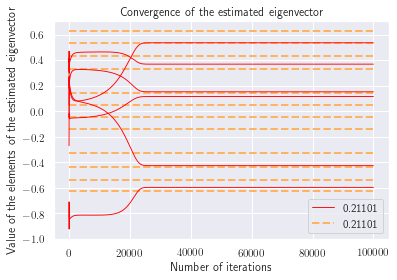

/home/oliver/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/oliver/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


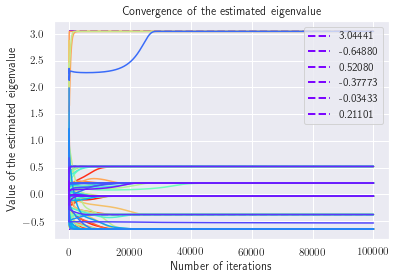

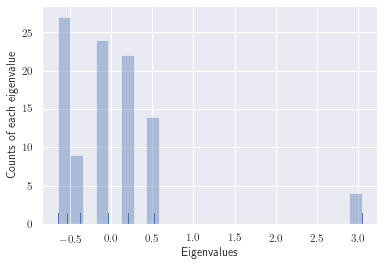

Number of mean iterations needed: 25767.0


In [5]:
# Visualization
color=iter(cm.rainbow(np.linspace(1,0,5)))
c = next(color)
for k in range(matrix_size):
    tmp_xaxis = len(x_trial_list[:,k])
    if k==0:
        plt.plot(np.linspace(1,tmp_xaxis,tmp_xaxis),x_trial_list[:,k],c=c,label="%2.5f" % eigenvalue,linewidth=0.9)
    else:
        plt.plot(np.linspace(1,tmp_xaxis,tmp_xaxis),x_trial_list[:,k],c=c,linewidth=0.9)

## Compare with the analytical solution
print("\n Numpy Eigenvalues: \n", numpy_eigenvalue)
print("\n Final Numerical Eigenvalue \n", eigenvalue)
diff = np.min(abs(numpy_eigenvalue - eigenvalue))
print("\n")
print('Absolute difference between Numpy Eigenvalue and TensorFlow DNN = ',np.max(diff))

# Finding which element of analytic our estimated eigenvalue converges to
index = np.argmin(abs(numpy_eigenvalue - eigenvalue))

print("numpy vec:", numpy_vector[index])
print("computed vec",x_dnn.T)

c = next(color)
for l in range(matrix_size):
    plt.hlines(numpy_vector[index][l],0,num_iter,colors=c,linestyles="dashed",linewidth=2)
    if l==(matrix_size-1):
        plt.hlines(-numpy_vector[index][l],0,num_iter,colors=c,linestyles="dashed",label="%2.5f" % numpy_eigenvalue[index],linewidth=2)
        break
    plt.hlines(-numpy_vector[index][l],0,num_iter,colors=c,linestyles="dashed",linewidth=2)
plt.xlabel(r"Number of iterations", size=12)
plt.ylabel(r"Value of the elements of the estimated eigenvector",size=12)
plt.legend()
plt.title(r"Convergence of the estimated eigenvector",size=12)
plt.savefig("convergence_eigenvector1.pdf")
plt.show()

color=iter(cm.rainbow(np.linspace(1,0,run_iter+1)))

iterations=np.linspace(1,num_iter,num_iter)
for i in range(runs+1):
    plt.plot(iterations,lambdas[i],c=c)
    c=next(color)

for l in range(matrix_size):
    plt.hlines(numpy_eigenvalue[l],0,num_iter,colors=c,linestyles="dashed",label="%2.5f" % numpy_eigenvalue[l],linewidth=2,)
plt.legend()
plt.xlabel(r"Number of iterations", size=12)
plt.ylabel(r"Value of the estimated eigenvalue",size=12)
plt.title(r"Convergence of the estimated eigenvalue",size=12)
plt.savefig("convergence_eigenvalue1.pdf")
plt.show()

#sns.set(color_codes=True)
sns.distplot(np.reshape(lambdas[:,-1],[1,int(run_iter)]), bins=matrix_size*4, kde=False, rug=True)
plt.ylabel(r"Counts of each eigenvalue",size=12)
plt.xlabel(r"Eigenvalues", size=12)
plt.savefig("histogram1.pdf")
plt.show()

print("Number of mean iterations needed:", np.mean(num_iter_needed))

As seen, the values in the estimated eigenvector does not exactly converge towards numpys eigenvector when we are using a random symmetric matrix, but does however yield the exact eigenvalue. It is the eigenvalue that we are after, and since it is exact, we do not dwell about the values in the eigenvector. 